In [1]:
from __future__ import print_function

import os
import sys
sys.path.insert(0, os.path.abspath("../.."))

# IBM PAIRS open-source module
from ibmpairs import paw

import numpy
import pandas
import geopandas
import shapely
from shapely import wkb, wkt
from datetime import datetime, timedelta
import pytz

import statsmodels.api as sm

import matplotlib
matplotlib.use('Agg')
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import cm

In [2]:
ROLLING_WINDOW=14

dt_cutoff_min = datetime(2020, 3, 5, tzinfo=pytz.utc)
print('Considering data from                      ', dt_cutoff_min)

dt_cutoff_latest = datetime(2020,8,2, tzinfo=pytz.utc)
print('Plotting data up to                        ', dt_cutoff_latest)

data_subdirectory = 'data/csv/run29RW14'
if not os.path.exists(data_subdirectory):
    os.makedirs(data_subdirectory)
print('data_subdirectory                          ', data_subdirectory)

Considering data from                       2020-03-05 00:00:00+00:00
Plotting data up to                         2020-08-02 00:00:00+00:00
data_subdirectory                           data/csv/run29RW14


In [3]:
PAIRS_USER              = ##############
PAIRS_SERVER            = ##############
BASE_URI                = ##############
PAIRS_PASSWORD          = ##############
PAIRS_CREDENTIALS       = ##############

def query_state(layerID, overwriteExisting=True):
    """
    layerID:
    JHU
    state cases:      P568C6015
    state fatalities: P568C6016

    MOBILITY
    state mobility:   P611C6298
    """
    coronaQueryDef = {
        "layers": [
            {"id": layerID},
        ],
        "spatial": {
            "type" :        "square",
            "coordinates" : [-89, -179, 89, 179], 
        },
        "temporal": {
            "intervals": [
                {
                    "start": "2019-03-01T00:00:00Z",
                    "end": "2030-03-10T23:59:59Z"
                }
            ]
        },
        "outputType": "csv"
    }

    # create PAIRS query instance
    coronaQuery = paw.PAIRSQuery(
        coronaQueryDef,
        pairsHost = 'https://'+PAIRS_SERVER,
        auth = PAIRS_CREDENTIALS,
        baseURI = BASE_URI,
        overwriteExisting = overwriteExisting,
    )
    # submit and download modified query
    coronaQuery.submit()
    coronaQuery.poll_till_finished(printStatus=True)
    coronaQuery.download()
    coronaQuery.create_layers()
    
    # associate vector data frame, and show the vector data
    coronaQuery.vdf = coronaQuery.data[list(coronaQuery.metadata.keys())[0]]

    # split property string into individual columns
    #coronaQuery.split_property_string_column()

    new = coronaQuery.vdf['Region'].str.split(':', expand=True)
    coronaQuery.vdf['pairs_id'] = new[0]
    coronaQuery.vdf['State'] = new[1]
    
    return coronaQuery

In [4]:
# State Mobility and Covid Data

# State Mobility
mobilityQueryState = query_state(layerID='P611C6298')
df_state_mobility = mobilityQueryState.vdf[['timestamp', 'pairs_id', 'State', 'Value']]
df_state_mobility = df_state_mobility.rename(columns={'Value': 'Mobility'})
df_state_mobility['pairs_id'] = df_state_mobility['pairs_id'].astype(int)

# Make a copy in the specific subfolder
df_state_mobility.to_csv(os.path.join(data_subdirectory, 'df_state_mobility.csv'), index=None)

# Read back covid data from csv
df_state_mobility = pandas.read_csv(os.path.join(data_subdirectory, 'df_state_mobility.csv'))
df_state_mobility['timestamp'] = pandas.to_datetime(df_state_mobility['timestamp'])
df_state_mobility.tail()

# State Cases
coronaQueryState = query_state(layerID='P568C6015')
df_state_cases = coronaQueryState.vdf[['timestamp', 'pairs_id', 'State', 'Value']]
df_state_cases = df_state_cases.rename(columns={'Value': 'Cases'})
df_state_cases['pairs_id'] = df_state_cases['pairs_id'].astype(int)

# Individual States found in df_region
df_region = df_state_cases[['pairs_id', 'State']].drop_duplicates().reset_index(drop=True)

# We are only interested in USA states so filter by pairs_id
df_region = df_region[(df_region['pairs_id']>=121)&(df_region['pairs_id']<=171)].reset_index(drop=True)
df_state_cases = df_state_cases[(df_state_cases['pairs_id']>=121)&(df_state_cases['pairs_id']<=171)].reset_index(drop=True)

state_pairs_ids = sorted(list(df_region['pairs_id']))

# Make a copy in the specific subfolder
df_state_cases.to_csv(os.path.join(data_subdirectory, 'df_state_cases.csv'), index=None)

# Read back covid data from csv
df_s = pandas.read_csv(os.path.join(data_subdirectory, 'df_state_cases.csv'))
df_s['timestamp'] = pandas.to_datetime(df_s['timestamp'])
df_s.tail()

No handlers could be found for logger "ibmpairs.paw"


timestamp  pairs_id             State  Cases
11725 2020-09-07 00:00:00+00:00       152  USA - New Mexico  26144
11726 2020-09-07 00:00:00+00:00       137      USA - Kansas  46337
11727 2020-09-07 00:00:00+00:00       166     USA - Vermont   1651
11728 2020-09-07 00:00:00+00:00       158      USA - Oregon  28190
11729 2020-09-07 00:00:00+00:00       136        USA - Iowa  70537

In [5]:
# Split country-state names into two columns
country_state = (' - ' + df_region['State']).str.rsplit(' - ', n=1, expand=True)
country_state[0] = country_state[0].str.replace(' - ', '')

df_region['Country'] = country_state[0]
df_region['State'] = country_state[1]

# Make a copy in the specific subfolder
df_region.to_csv(os.path.join(data_subdirectory, 'df_region_STATE.csv'), index=None)

# Read back covid data from csv
df_region = pandas.read_csv(os.path.join(data_subdirectory, 'df_region_STATE.csv'))
df_region.tail()

pairs_id       State Country
46       139   Louisiana     USA
47       167    Virginia     USA
48       121     Alabama     USA
49       152  New Mexico     USA
50       126    Colorado     USA

In [6]:
# Unstacking COVID19 and mobility

# Unstack the COVID19 data and first derivative (new cases)
df_unstacked = df_s.copy()
del df_unstacked['State']

df_unstacked = df_unstacked.set_index(['timestamp', 'pairs_id']).unstack().reset_index().sort_values(by='timestamp').set_index('timestamp')
df_unstacked = df_unstacked.swaplevel(axis=1)
df_unstacked = df_unstacked.replace(0, numpy.nan)

# Replace values where no change with nan so that the daily numbers make sense when reporting only every couple of days
# (also replace values with negative change)
df_unstacked[df_unstacked.diff()<=0] = numpy.nan

# Interpolate
df_unstacked = df_unstacked.interpolate(method='linear', limit_area='inside')

# New Local Cases (1st derivative)
df_new = df_unstacked.diff()


# Unstack the mobility data
df_m_unstacked = df_state_mobility[df_state_mobility['pairs_id'].isin(state_pairs_ids)]
del df_m_unstacked['State']

df_m_unstacked = df_m_unstacked.set_index(['timestamp', 'pairs_id']).unstack().reset_index().sort_values(by='timestamp').set_index('timestamp')
df_m_unstacked = df_m_unstacked.swaplevel(axis=1)

# Erase high-value mobility outliers >100miles before taking the rolling mean
df_m_unstacked = df_m_unstacked.clip(upper=100)

# Interpolate
df_m_unstacked = df_m_unstacked.interpolate(method='linear', limit_area='inside')

df_m_unstacked.tail()


# Stack and merge in order to fill in nan at all missing combinations
df_stacked = pandas.merge(df_new.stack(level='pairs_id').reset_index(),
                          df_m_unstacked.stack(level='pairs_id').reset_index(),
                          on=['timestamp', 'pairs_id'],
                          how='outer'
                         )
df_stacked['pairs_id'] = df_stacked['pairs_id'].astype(int)

# Unstack again
df_stacked = df_stacked.set_index(['timestamp', 'pairs_id']).unstack().reset_index().sort_values(
    by='timestamp').set_index('timestamp')

df_new = df_stacked[['Cases']].swaplevel(axis=1)
df_m_unstacked = df_stacked[['Mobility']].swaplevel(axis=1)

df_new.tail()

pairs_id                      121    122     123     124     125    126  \
                            Cases  Cases   Cases   Cases   Cases  Cases   
timestamp                                                                 
2020-09-03 00:00:00+00:00  1046.0  102.0  1092.0   969.0  4737.0  268.0   
2020-09-04 00:00:00+00:00  1108.0  120.0   728.0  1094.0  4644.0  349.5   
2020-09-05 00:00:00+00:00  1410.0   93.0   836.0   515.0  4652.0  349.5   
2020-09-06 00:00:00+00:00   511.0   83.0   250.0   687.0  3542.0  285.0   
2020-09-07 00:00:00+00:00   659.0   33.0   197.0   350.0  2109.0  213.0   

pairs_id                     127    128   129     130  ...    162     163  \
                           Cases  Cases Cases   Cases  ...  Cases   Cases   
timestamp                                              ...                  
2020-09-03 00:00:00+00:00  101.0  104.0  58.0  3571.0  ...  334.0  1715.0   
2020-09-04 00:00:00+00:00  156.0   99.0  51.0  3198.0  ...  259.0  1051.0   
2020-09-05 00:00:00+00:00    NaN  140.0  52.0  3656.0  ...  293.0  1765.0   
2020-09-06 00:00:00+00:00    NaN  151.0  41.0  2564.0  ...  220.0  1764.0   
2020-09-07 00:00:00+00:00    NaN  206.0  36.0  1838.0  ...  191.0   983.0   

pairs_id                      164    165   166     167    168    169     170  \
                            Cases  Cases Cases   Cases  Cases  Cases   Cases   
timestamp                                                                      
2020-09-03 00:00:00+00:00  3567.0  504.0   2.5  1119.0  479.0  197.0   727.0   
2020-09-04 00:00:00+00:00  5928.0  513.0   2.5  1101.0  479.0  187.0  1498.0   
2020-09-05 00:00:00+00:00  4465.0  433.0   5.0   943.0  501.0  251.0   946.0   
2020-09-06 00:00:00+00:00  2387.0  388.0   1.0  1196.0  399.0  125.0   893.0   
2020-09-07 00:00:00+00:00   839.0  373.0   3.0   639.0  310.0  157.0   567.0   

pairs_id                    171  
                          Cases  
timestamp                        
2020-09-03 00:00:00+00:00  30.0  
2020-09-04 00:00:00+00:00  49.0  
2020-09-05 00:00:00+00:00  21.0  
2020-09-06 00:00:00+00:00  21.0  
2020-09-07 00:00:00+00:00   NaN  

[5 rows x 51 columns]

In [7]:
def process_covid_state(df_new, rolling_window_log, rolling_window_growth):
    """
    :df_new:    DataFrame with the new cases and fatalities
    
    Returns: df_log_new (Semi-log cleaned up daily cases and fatalities)
    Returns: df_log_new_rolling (Semi-log cleaned up daily data with 5 day rolling mean)
    Returns: df_growth (Growth in daily cases and fatalities)
    """
    # Build a semi-log version of the data and clean up
    df_log_new = df_new.copy()
    df_log_new[df_log_new<=0] = numpy.nan
    df_log_new = df_log_new.apply(lambda x: numpy.log(x))
    df_log_new = df_log_new.replace([numpy.inf, -numpy.inf], numpy.nan)
    
    # Remove outliers (non-symmetrical so that we don't erase too many valid high-value outliers)
    df_log_new[(df_log_new < df_log_new.rolling(3, center=True).mean() - 0.8) | 
               ((df_log_new > df_log_new.rolling(3, center=True).mean() + 1.2) & (df_log_new > 4))] = numpy.nan
    
    # Interpolate to fill in missing values
    df_log_new = df_log_new.interpolate(method='linear', limit_area='inside')
    
    # Rolling Mean
    df_log_new_rolling = df_log_new.rolling(rolling_window_log, min_periods=1).mean()
    
    # Growth rate (don't use min_periods=1 because it generates too many outliers)
    df_growth = df_log_new_rolling.diff()

    # Mask bad growth values due to derivatives of small numbers
    SMALL_VALUE = -1
    df_growth[df_log_new<=SMALL_VALUE] = numpy.nan

    # Interpolate inside to fill in missing values
    df_growth = df_growth.interpolate(method='linear', limit_area='inside')
    
    # Filling outside nans with zero
    df_growth = df_growth.fillna(0)
    
    # Apply rolling mean for growth
    df_growth = df_growth.rolling(rolling_window_growth, min_periods=1).mean()
    
    return df_log_new, df_log_new_rolling, df_growth

In [8]:
# Process the Covid data 
df_log_new, df_log_new_rolling, df_growth\
    = process_covid_state(df_new.swaplevel(axis=1)[['Cases']].swaplevel(axis=1),
                          rolling_window_log=ROLLING_WINDOW, 
                          rolling_window_growth=ROLLING_WINDOW)

df_log_new_rolling.tail()

pairs_id                        121       122       123       124       125  \
                              Cases     Cases     Cases     Cases     Cases   
timestamp                                                                     
2020-09-03 00:00:00+00:00  7.093108  4.136404  6.255822  6.315228  8.550994   
2020-09-04 00:00:00+00:00  7.088429  4.176974  6.267407  6.330211  8.525531   
2020-09-05 00:00:00+00:00  7.120497  4.180114  6.254899  6.325905  8.513117   
2020-09-06 00:00:00+00:00  7.118159  4.198683  6.268036  6.369148  8.490741   
2020-09-07 00:00:00+00:00  7.052602  4.145997  6.235422  6.375549  8.412790   

pairs_id                        126       127       128       129       130  \
                              Cases     Cases     Cases     Cases     Cases   
timestamp                                                                     
2020-09-03 00:00:00+00:00  5.627457  4.899251  4.066174  3.915208  8.086614   
2020-09-04 00:00:00+00:00  5.632319  4.940962  4.112165  3.903600  8.059355   
2020-09-05 00:00:00+00:00  5.637182  4.928738  4.175108  3.887661  8.047583   
2020-09-06 00:00:00+00:00  5.644015  4.914478  4.233150  3.865391  8.036988   
2020-09-07 00:00:00+00:00  5.649231  4.897624  4.338702  3.843369  8.022287   

pairs_id                   ...       162       163       164       165  \
                           ...     Cases     Cases     Cases     Cases   
timestamp                  ...                                           
2020-09-03 00:00:00+00:00  ...  5.485417  7.233897  8.415897  5.922388   
2020-09-04 00:00:00+00:00  ...  5.506427  7.200862  8.419076  5.929713   
2020-09-05 00:00:00+00:00  ...  5.517479  7.226137  8.432172  5.941138   
2020-09-06 00:00:00+00:00  ...  5.549255  7.222583  8.382932  5.959273   
2020-09-07 00:00:00+00:00  ...  5.566993  7.250284  8.267429  5.988139   

pairs_id                        166       167       168       169       170  \
                              Cases     Cases     Cases     Cases     Cases   
timestamp                                                                     
2020-09-03 00:00:00+00:00  1.913951  6.878293  6.098686  4.802689  6.473773   
2020-09-04 00:00:00+00:00  1.880379  6.886755  6.113368  4.854924  6.516293   
2020-09-05 00:00:00+00:00  1.817845  6.868888  6.078525  4.915162  6.515992   
2020-09-06 00:00:00+00:00  1.815540  6.889836  6.075373  4.940231  6.564470   
2020-09-07 00:00:00+00:00  1.737068  6.887202  6.064891  5.034415  6.590834   

pairs_id                        171  
                              Cases  
timestamp                            
2020-09-03 00:00:00+00:00  3.410374  
2020-09-04 00:00:00+00:00  3.388026  
2020-09-05 00:00:00+00:00  3.395174  
2020-09-06 00:00:00+00:00  3.358687  
2020-09-07 00:00:00+00:00  3.369441  

[5 rows x 51 columns]

In [9]:
# Mobility rolling mean
df_Mobility_rolling = df_m_unstacked.rolling(ROLLING_WINDOW, min_periods=1).mean()

# LogMobility rolling mean
df_LogMobility_rolling = df_Mobility_rolling.swaplevel(axis=1).rename(
    columns={'Mobility': 'LogMobility'}).swaplevel(axis=1).apply(lambda x: numpy.log10(x))

df_LogMobility_rolling.tail()

pairs_id                          121         122         123         124  \
                          LogMobility LogMobility LogMobility LogMobility   
timestamp                                                                   
2020-09-03 00:00:00+00:00    0.955873    0.555552    0.590356    0.889446   
2020-09-04 00:00:00+00:00    0.957429    0.551772    0.588432    0.886817   
2020-09-05 00:00:00+00:00    0.957347    0.549091    0.586812    0.882866   
2020-09-06 00:00:00+00:00    0.966651    0.563362    0.601333    0.889043   
2020-09-07 00:00:00+00:00    0.968043    0.563827    0.604262    0.888535   

pairs_id                          125         126         127         128  \
                          LogMobility LogMobility LogMobility LogMobility   
timestamp                                                                   
2020-09-03 00:00:00+00:00    0.434672    0.682835    0.656221    0.729165   
2020-09-04 00:00:00+00:00    0.432809    0.679441    0.649363    0.721457   
2020-09-05 00:00:00+00:00    0.430110    0.678219    0.645689    0.715800   
2020-09-06 00:00:00+00:00    0.448849    0.689077    0.652856    0.723973   
2020-09-07 00:00:00+00:00    0.453560    0.690226    0.651577    0.722229   

pairs_id                          129         130  ...         162  \
                          LogMobility LogMobility  ... LogMobility   
timestamp                                          ...               
2020-09-03 00:00:00+00:00    0.160404    0.760842  ...    0.757532   
2020-09-04 00:00:00+00:00    0.159159    0.759177  ...    0.755009   
2020-09-05 00:00:00+00:00    0.169065    0.757694  ...    0.752449   
2020-09-06 00:00:00+00:00    0.173836    0.770138  ...    0.757974   
2020-09-07 00:00:00+00:00    0.177753    0.771140  ...    0.760674   

pairs_id                          163         164         165         166  \
                          LogMobility LogMobility LogMobility LogMobility   
timestamp                                                                   
2020-09-03 00:00:00+00:00    0.905877    0.787293    0.695056    0.649001   
2020-09-04 00:00:00+00:00    0.904916    0.786193    0.694053    0.644101   
2020-09-05 00:00:00+00:00    0.903938    0.784678    0.693758    0.638746   
2020-09-06 00:00:00+00:00    0.911072    0.794756    0.713154    0.648450   
2020-09-07 00:00:00+00:00    0.910842    0.794697    0.712495    0.651343   

pairs_id                          167         168         169         170  \
                          LogMobility LogMobility LogMobility LogMobility   
timestamp                                                                   
2020-09-03 00:00:00+00:00    0.712000    0.622983    0.779462    0.776411   
2020-09-04 00:00:00+00:00    0.708506    0.621384    0.776820    0.772049   
2020-09-05 00:00:00+00:00    0.706639    0.617906    0.774371    0.768406   
2020-09-06 00:00:00+00:00    0.715193    0.629629    0.782737    0.773910   
2020-09-07 00:00:00+00:00    0.714965    0.629418    0.782652    0.773671   

pairs_id                          171  
                          LogMobility  
timestamp                              
2020-09-03 00:00:00+00:00    0.671239  
2020-09-04 00:00:00+00:00    0.669078  
2020-09-05 00:00:00+00:00    0.665862  
2020-09-06 00:00:00+00:00    0.671180  
2020-09-07 00:00:00+00:00    0.671690  

[5 rows x 51 columns]

In [10]:
# Filter out data before dt_cutoff_min. Corona numbers are too low. 
# We are doing this here AFTER the rolling means have been applied
del df_new
del df_log_new
df_LogCases = df_log_new_rolling[df_log_new_rolling.index>=dt_cutoff_min].swaplevel(axis=1)['Cases']
del df_log_new_rolling
df_GrowthCases = df_growth[df_growth.index>=dt_cutoff_min].swaplevel(axis=1)['Cases']
del df_growth
#df_Mobility = df_Mobility_rolling[df_Mobility_rolling.index>=dt_cutoff_min].swaplevel(axis=1)['Mobility']
del df_Mobility_rolling
df_LogMobility = df_LogMobility_rolling[df_LogMobility_rolling.index>=dt_cutoff_min].swaplevel(axis=1)['LogMobility']
del df_LogMobility_rolling

In [11]:
# Make a copy in the specific subfolder
df_LogCases.to_csv(os.path.join(data_subdirectory, 'df_LogCases_STATE.csv'))

# Make a copy in the specific subfolder
df_GrowthCases.to_csv(os.path.join(data_subdirectory, 'df_GrowthCases_STATE.csv'))

# Make a copy in the specific subfolder
df_LogMobility.to_csv(os.path.join(data_subdirectory, 'df_LogMobility_STATE.csv'))

/home/ipython/software/python2/virtualenv/pypairs-latest/lib/python2.7/site-packages/pandas/core/arrays/datetimes.py:1172: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  "will drop timezone information.", UserWarning)


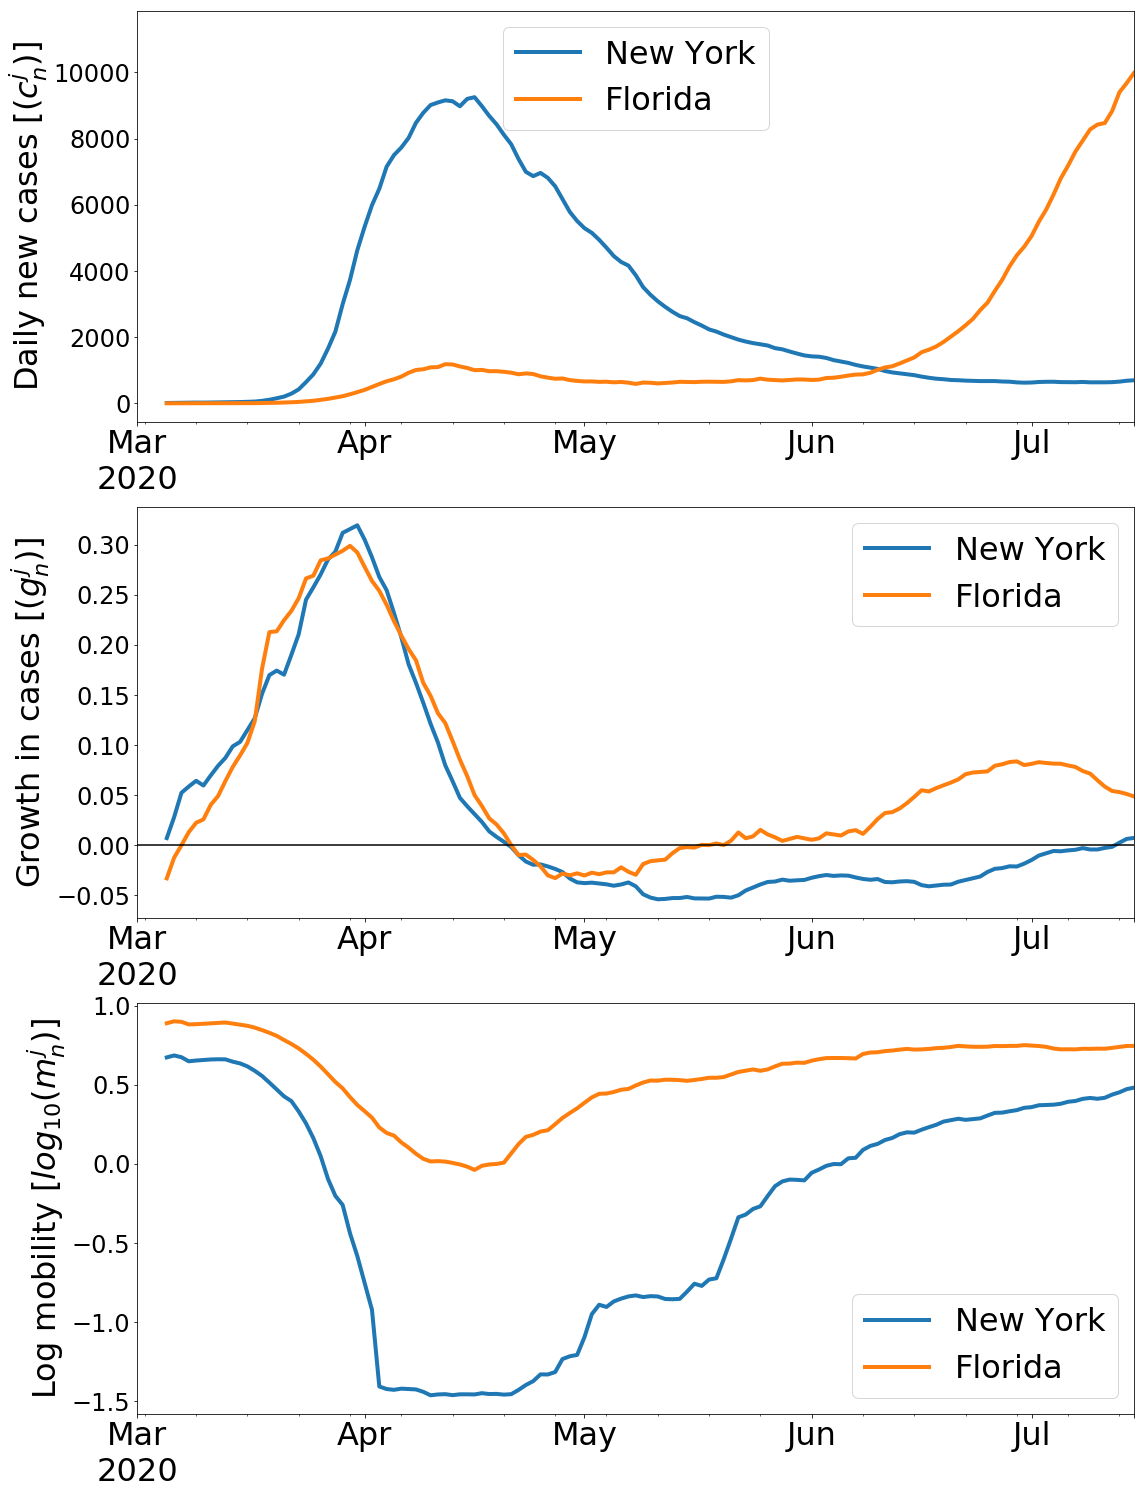

In [12]:
df_states_chosen = df_region[df_region['State'].isin(['Florida', 'New York'])]

plt.figure(figsize=(16,20))
ax = plt.subplot(3,1,1)
df_plot = numpy.exp(df_LogCases).copy()
df_plot = df_plot[df_states_chosen['pairs_id']]
df_plot.plot(ax=ax, lw=4)
plt.xticks(fontsize=32)
plt.yticks(fontsize=24)
plt.legend(df_states_chosen['State'], fontsize=32)
plt.xlabel('', size=32)
plt.ylabel('Daily new cases [$(c^j_n)$]', size=32)
plt.xlim(xmin=datetime(2020,3,1, tzinfo=pytz.utc))
plt.xlim(xmax=datetime(2020,7,15, tzinfo=pytz.utc))
plt.tight_layout()

ax = plt.subplot(3,1,2)
df_plot = df_GrowthCases.copy()
df_plot = df_plot[df_states_chosen['pairs_id']]
df_plot.plot(ax=ax, lw=4)
plt.xticks(fontsize=32)
plt.yticks(fontsize=24)
plt.axhline(c='k')
plt.legend(df_states_chosen['State'], fontsize=32)
plt.xlabel('', size=32)
plt.ylabel('Growth in cases [$(g^j_n)$]', size=32)
plt.xlim(xmin=datetime(2020,3,1, tzinfo=pytz.utc))
plt.xlim(xmax=datetime(2020,7,15, tzinfo=pytz.utc))

ax = plt.subplot(3,1,3)
df_plot = df_LogMobility.copy()
df_plot.index = df_plot.index.to_period(freq='D')
df_plot = df_plot[df_states_chosen['pairs_id']]
df_plot.plot(ax=ax, lw=4)
plt.xticks(fontsize=32)
plt.yticks(fontsize=24)
plt.legend(df_states_chosen['State'], fontsize=32)
plt.xlabel('', size=12)
plt.ylabel('Log mobility [$log_{10}(m^j_n)$]', size=32)
plt.xlim(xmin=datetime(2020,3,1, tzinfo=pytz.utc))
plt.xlim(xmax=datetime(2020,7,15, tzinfo=pytz.utc))

#plt.tight_layout()
plt.show()

In [13]:
# df1: LogMobility
df1 = df_LogMobility.bfill().ffill()
# Create the multiindex
df1.columns = pandas.MultiIndex.from_product([df1.columns, ['LogMobility']])
df1.columns.names = ['pairs_id', None]

# df2: GrowthCases
# Note: no .bfill().ffill() for GrowthCases. Instead fillna(0) before taking rolling mean
df2 = df_GrowthCases
# Create the multiindex
df2.columns = pandas.MultiIndex.from_product([df2.columns, ['GrowthCases']])
df2.columns.names = ['pairs_id', None]

df_joined = df1.join(df2)
df_joined = df_joined.swaplevel(axis=1)

# Write to disk
df_joined.to_csv(os.path.join(data_subdirectory, 'df_joined_STATE.csv'))

df_joined.tail()

LogMobility                                          \
pairs_id                          121       122       123       124       125   
timestamp                                                                       
2020-09-03 00:00:00+00:00    0.955873  0.555552  0.590356  0.889446  0.434672   
2020-09-04 00:00:00+00:00    0.957429  0.551772  0.588432  0.886817  0.432809   
2020-09-05 00:00:00+00:00    0.957347  0.549091  0.586812  0.882866  0.430110   
2020-09-06 00:00:00+00:00    0.966651  0.563362  0.601333  0.889043  0.448849   
2020-09-07 00:00:00+00:00    0.968043  0.563827  0.604262  0.888535  0.453560   

                                                                             \
pairs_id                        126       127       128       129       130   
timestamp                                                                     
2020-09-03 00:00:00+00:00  0.682835  0.656221  0.729165  0.160404  0.760842   
2020-09-04 00:00:00+00:00  0.679441  0.649363  0.721457  0.159159  0.759177   
2020-09-05 00:00:00+00:00  0.678219  0.645689  0.715800  0.169065  0.757694   
2020-09-06 00:00:00+00:00  0.689077  0.652856  0.723973  0.173836  0.770138   
2020-09-07 00:00:00+00:00  0.690226  0.651577  0.722229  0.177753  0.771140   

                           ... GrowthCases                                \
pairs_id                   ...         162       163       164       165   
timestamp                  ...                                             
2020-09-03 00:00:00+00:00  ...    0.065043 -0.008542 -0.028845  0.003950   
2020-09-04 00:00:00+00:00  ...    0.063086 -0.008980 -0.027270  0.004440   
2020-09-05 00:00:00+00:00  ...    0.059478 -0.005261 -0.023620  0.005352   
2020-09-06 00:00:00+00:00  ...    0.061254 -0.004814 -0.026217  0.007782   
2020-09-07 00:00:00+00:00  ...    0.057707  0.000169 -0.032469  0.010123   

                                                                             \
pairs_id                        166       167       168       169       170   
timestamp                                                                     
2020-09-03 00:00:00+00:00  0.012949  0.000902 -0.019070  0.003712 -0.007358   
2020-09-04 00:00:00+00:00  0.009083  0.005194 -0.015261  0.010807 -0.003402   
2020-09-05 00:00:00+00:00  0.001080  0.004307 -0.017049  0.015249 -0.002382   
2020-09-06 00:00:00+00:00  0.002054  0.005832 -0.015871  0.019108  0.002690   
2020-09-07 00:00:00+00:00 -0.009157  0.005644 -0.014217  0.027823  0.005885   

                                     
pairs_id                        171  
timestamp                            
2020-09-03 00:00:00+00:00 -0.000152  
2020-09-04 00:00:00+00:00 -0.003557  
2020-09-05 00:00:00+00:00 -0.004253  
2020-09-06 00:00:00+00:00 -0.006859  
2020-09-07 00:00:00+00:00 -0.010053  

[5 rows x 102 columns]

/home/ipython/software/python2/virtualenv/pypairs-latest/lib/python2.7/site-packages/numpy/lib/function_base.py:2522: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/home/ipython/software/python2/virtualenv/pypairs-latest/lib/python2.7/site-packages/numpy/lib/function_base.py:2451: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)


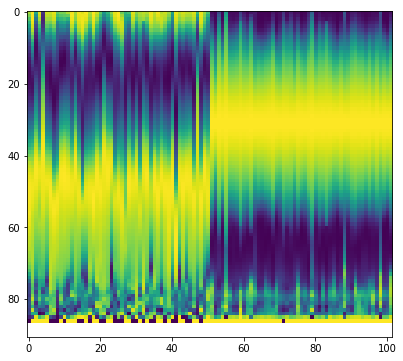

19 0.9093006204225837


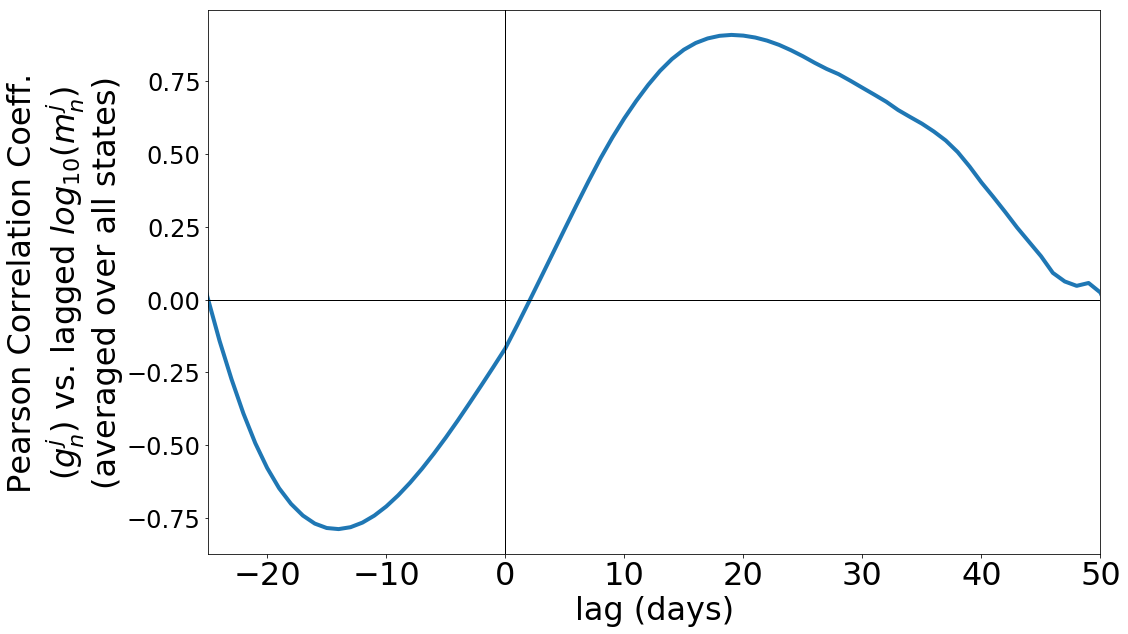

In [14]:
# Correlation with LogMobility
lag_days = numpy.arange(91) - 31
dt_cutoff_start = datetime(2020, 1, 1, tzinfo=pytz.utc)
dt_cutoff_end = datetime(2020, 4, 30, tzinfo=pytz.utc)
df_lagged_correlation = pandas.DataFrame()
for pairs_id in df_region['pairs_id'].values:
    df = df_joined[['LogMobility', 'GrowthCases']].swaplevel(axis=1)[pairs_id]
    df = df[df.index>=dt_cutoff_start]
    df = df[df.index<=dt_cutoff_end]

    lagged_correlation = pandas.DataFrame.from_dict(
        {x: [df['LogMobility'].corr(df[x].shift(-t)) for t in lag_days] for x in df.columns})
    lagged_correlation['pairs_id'] = pairs_id
    lagged_correlation['lag_days'] = lag_days
    df_lagged_correlation = pandas.concat([df_lagged_correlation, lagged_correlation])
    
df_lagged_correlation = df_lagged_correlation.set_index(['lag_days', 'pairs_id']).unstack()

plt.figure(figsize=(20,6))
plt.imshow(df_lagged_correlation)
plt.show()

df_lagged_correlation.head()

from matplotlib.offsetbox import AnchoredText
plt.figure(figsize=(16,10))
ax = plt.subplot(1,1,1)
plt.plot(df_lagged_correlation['GrowthCases'].mean(axis=1), lw=4)
plt.xlabel('lag (days)', size=32)
plt.ylabel('Pearson Correlation Coeff.\n$(g^j_n)$ vs. lagged $log_{10}(m^j_n)$\n(averaged over all states)', size=32)
plt.axvline(color='k', lw=1)
plt.axhline(color='k', lw=1)
plt.xticks(fontsize=32)
plt.yticks(fontsize=24)
plt.xlim(xmin=-25, xmax=50)

cases_lag_measured = df_lagged_correlation['GrowthCases'].mean(axis=1).idxmax()
print(cases_lag_measured, df_lagged_correlation.loc[cases_lag_measured, 'GrowthCases'].mean())

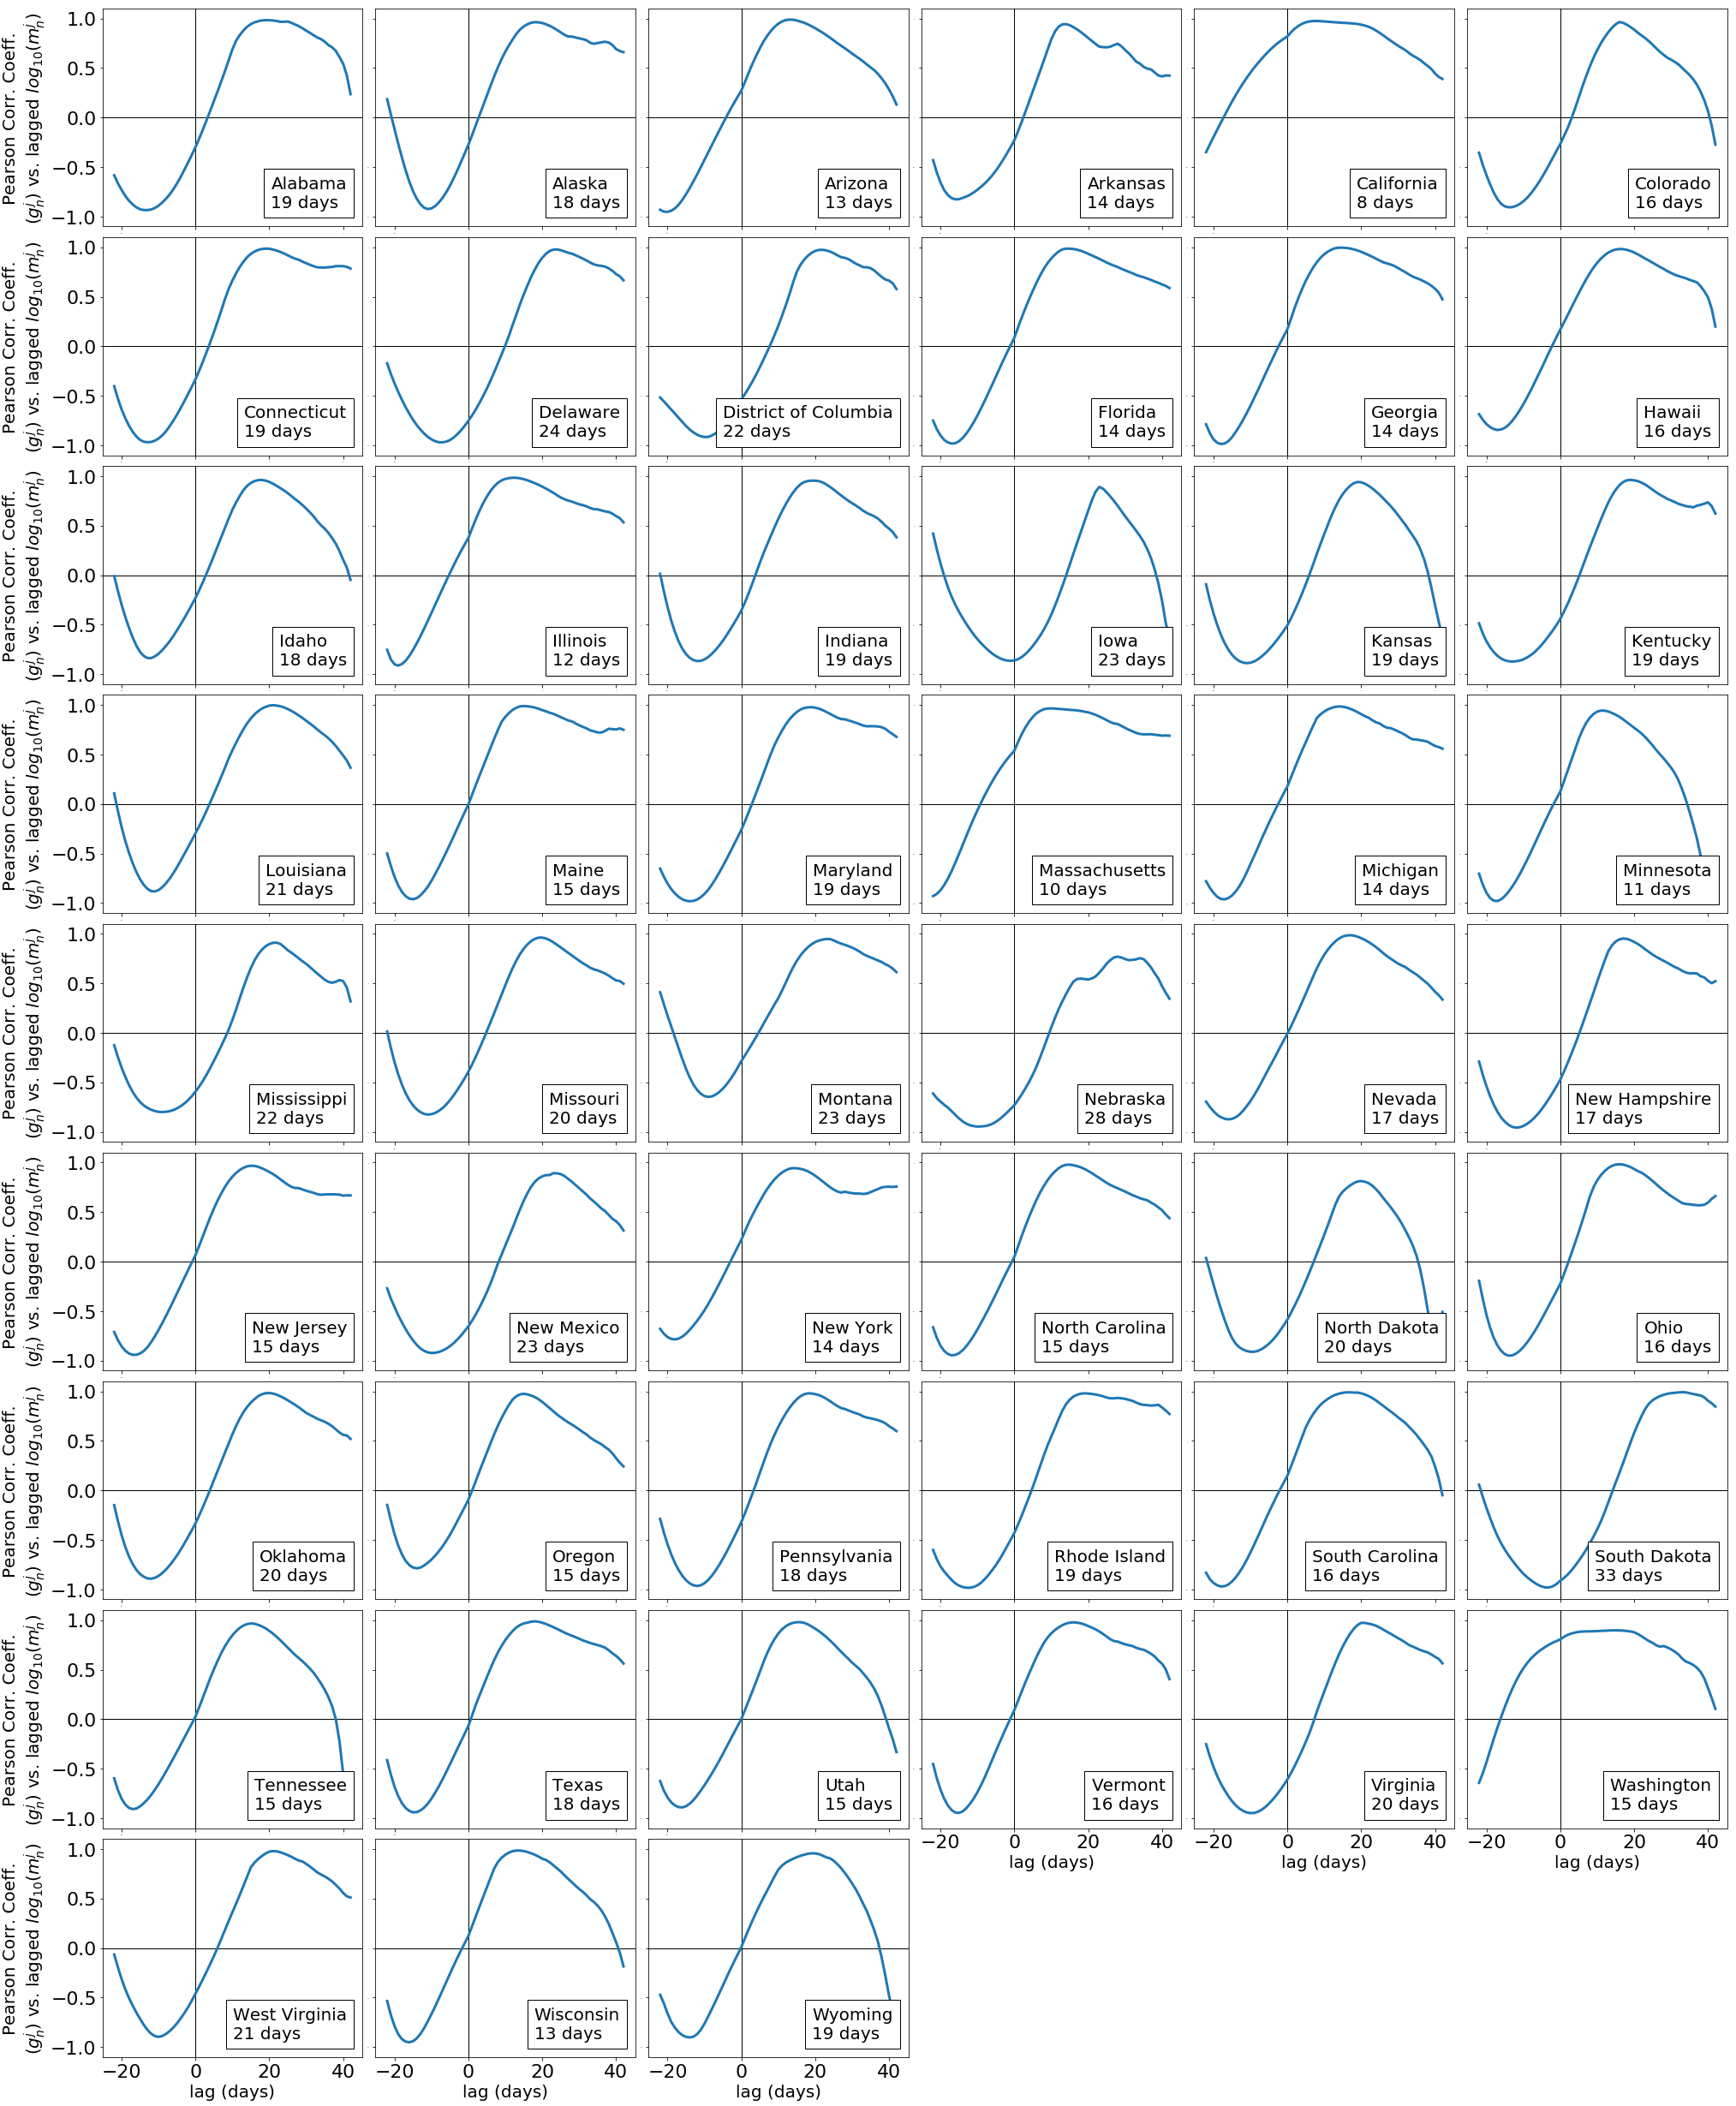

In [15]:
# Individual State Correlations
df_state_correlations = pandas.DataFrame()

fig = plt.figure(figsize=(34, 44)) # letter size 8.5 * 11
fig.subplots_adjust(hspace=0.05, wspace=0.05)

for i, pairs_id in enumerate(df_region.sort_values(by='State')['pairs_id'].values):

    df_single = df_lagged_correlation['GrowthCases'][pairs_id]
    df_single = df_single.loc[-22:42]

    row = {}
    row['pairs_id'] = pairs_id
    row['State'] = df_region[df_region['pairs_id']==pairs_id]['State'].values[0]
    row['argmax'] = df_single.idxmax()
    row['R'] = numpy.round(df_single.max(), 2)
    
    if len(df_single)>0:
        ax = plt.subplot(9, 6,i+1)
        plt.axhline(color='k', lw=1)
        plt.axvline(color='k', lw=1)
        
        plt.plot(df_single, lw=3)

        title_string = df_region[df_region['pairs_id']==pairs_id]['State'].values[0]

        ax.locator_params(tight=True, nbins=5)
            
        #plt.xlim(xmin=-2.5, xmax=1.5)
        plt.ylim(ymin=-1.1, ymax=1.1)

        anchored_text = AnchoredText(title_string + '\n' + str(row['argmax']) + ' days', loc=4, prop=dict(size=20))
        ax.add_artist(anchored_text)

        df_state_correlations = df_state_correlations.append(pandas.DataFrame(row, index=[0]))

        if (i>44):
            plt.xlabel('lag (days)', size=20)
            plt.xticks(fontsize=22)
        else:
            plt.xticks(fontsize=0)
            
        if (i%6==0):
            plt.ylabel('Pearson Corr. Coeff.\n$(g^j_n)$ vs. lagged $log_{10}(m^j_n)$', size=20)
            plt.yticks(fontsize=22)
        else:
            plt.yticks(fontsize=0)

#plt.tight_layout()
plt.savefig(os.path.join(data_subdirectory, 'state_correlations_RW14.svg'))
plt.show()

In [16]:
df_state_correlations[['argmax', 'R']].describe()

argmax          R
count  51.000000  51.000000
mean   17.647059   0.959412
std     4.399198   0.043100
min     8.000000   0.770000
25%    15.000000   0.955000
50%    18.000000   0.970000
75%    20.000000   0.980000
max    33.000000   1.000000

In [17]:
lag_cases = cases_lag_measured
print('cases_lag_measured', cases_lag_measured)
# Shifting only the growth
df_lagged_growth_cases = df_joined[['GrowthCases']].shift(periods=-lag_cases)
df_lagged = pandas.merge(df_joined[['LogMobility']],
                          df_joined[['GrowthCases']].shift(periods=-lag_cases),
                          left_index=True,
                          right_index=True)

df_lagged = df_lagged.swaplevel(axis=1)
df_lagged.tail()

cases_lag_measured 19


pairs_id                          121         122         123         124  \
                          LogMobility LogMobility LogMobility LogMobility   
timestamp                                                                   
2020-09-03 00:00:00+00:00    0.955873    0.555552    0.590356    0.889446   
2020-09-04 00:00:00+00:00    0.957429    0.551772    0.588432    0.886817   
2020-09-05 00:00:00+00:00    0.957347    0.549091    0.586812    0.882866   
2020-09-06 00:00:00+00:00    0.966651    0.563362    0.601333    0.889043   
2020-09-07 00:00:00+00:00    0.968043    0.563827    0.604262    0.888535   

pairs_id                          125         126         127         128  \
                          LogMobility LogMobility LogMobility LogMobility   
timestamp                                                                   
2020-09-03 00:00:00+00:00    0.434672    0.682835    0.656221    0.729165   
2020-09-04 00:00:00+00:00    0.432809    0.679441    0.649363    0.721457   
2020-09-05 00:00:00+00:00    0.430110    0.678219    0.645689    0.715800   
2020-09-06 00:00:00+00:00    0.448849    0.689077    0.652856    0.723973   
2020-09-07 00:00:00+00:00    0.453560    0.690226    0.651577    0.722229   

pairs_id                          129         130  ...         162  \
                          LogMobility LogMobility  ... GrowthCases   
timestamp                                          ...               
2020-09-03 00:00:00+00:00    0.160404    0.760842  ...         NaN   
2020-09-04 00:00:00+00:00    0.159159    0.759177  ...         NaN   
2020-09-05 00:00:00+00:00    0.169065    0.757694  ...         NaN   
2020-09-06 00:00:00+00:00    0.173836    0.770138  ...         NaN   
2020-09-07 00:00:00+00:00    0.177753    0.771140  ...         NaN   

pairs_id                          163         164         165         166  \
                          GrowthCases GrowthCases GrowthCases GrowthCases   
timestamp                                                                   
2020-09-03 00:00:00+00:00         NaN         NaN         NaN         NaN   
2020-09-04 00:00:00+00:00         NaN         NaN         NaN         NaN   
2020-09-05 00:00:00+00:00         NaN         NaN         NaN         NaN   
2020-09-06 00:00:00+00:00         NaN         NaN         NaN         NaN   
2020-09-07 00:00:00+00:00         NaN         NaN         NaN         NaN   

pairs_id                          167         168         169         170  \
                          GrowthCases GrowthCases GrowthCases GrowthCases   
timestamp                                                                   
2020-09-03 00:00:00+00:00         NaN         NaN         NaN         NaN   
2020-09-04 00:00:00+00:00         NaN         NaN         NaN         NaN   
2020-09-05 00:00:00+00:00         NaN         NaN         NaN         NaN   
2020-09-06 00:00:00+00:00         NaN         NaN         NaN         NaN   
2020-09-07 00:00:00+00:00         NaN         NaN         NaN         NaN   

pairs_id                          171  
                          GrowthCases  
timestamp                              
2020-09-03 00:00:00+00:00         NaN  
2020-09-04 00:00:00+00:00         NaN  
2020-09-05 00:00:00+00:00         NaN  
2020-09-06 00:00:00+00:00         NaN  
2020-09-07 00:00:00+00:00         NaN  

[5 rows x 102 columns]

/home/ipython/software/python2/virtualenv/pypairs-latest/lib/python2.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


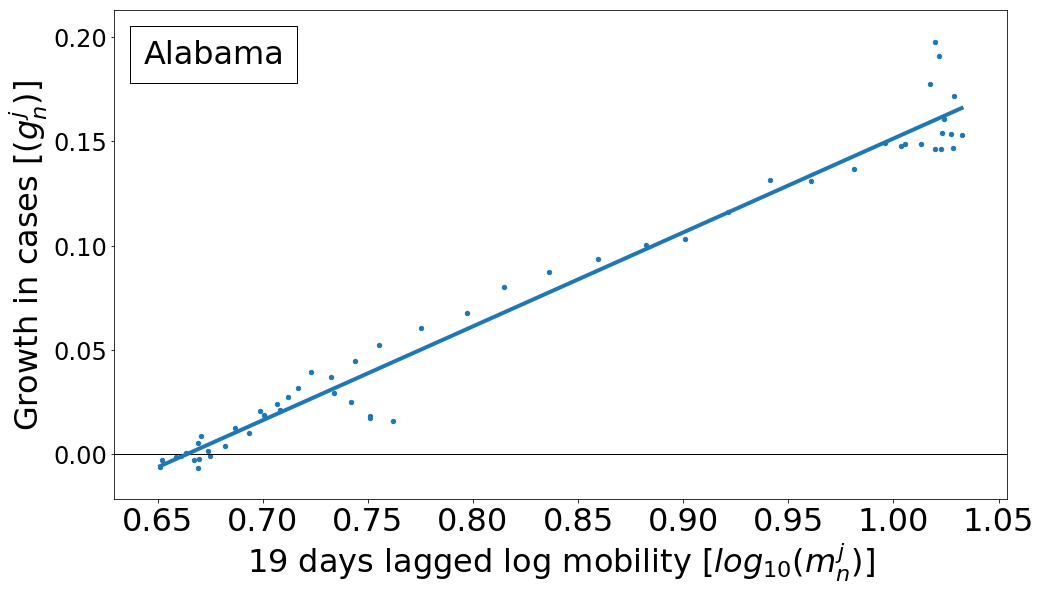

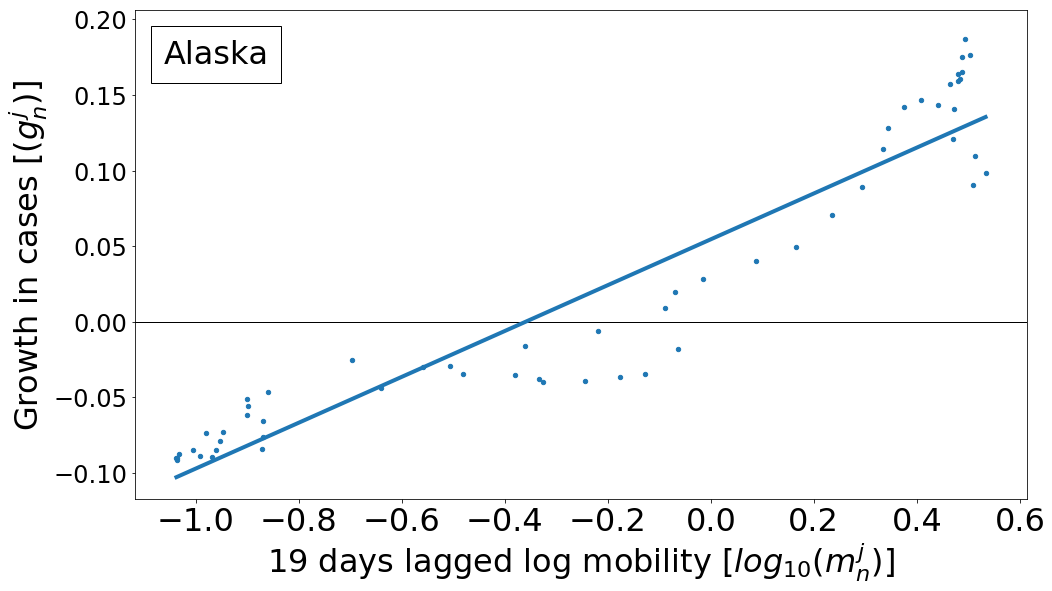

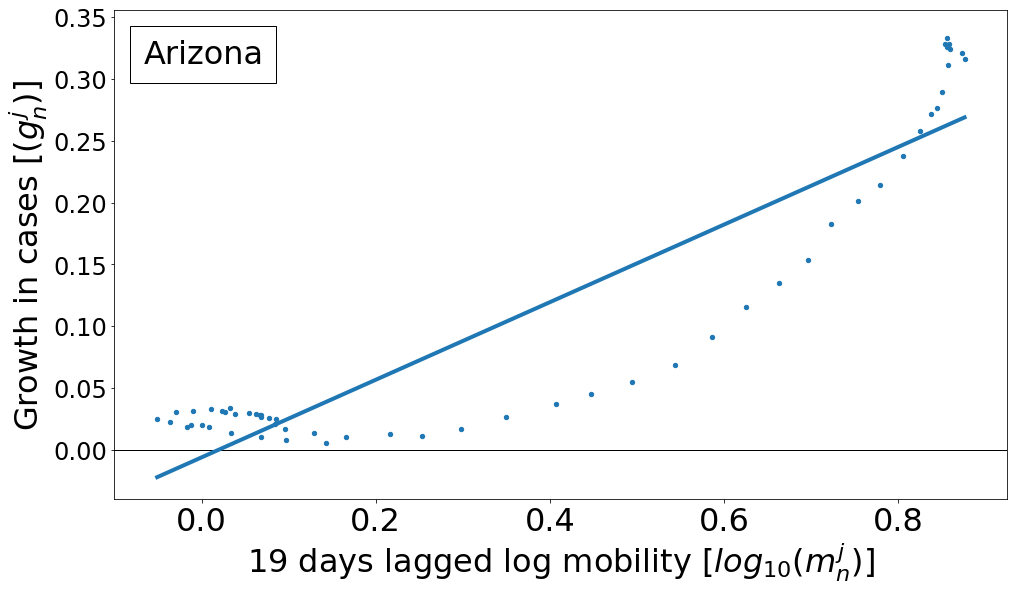

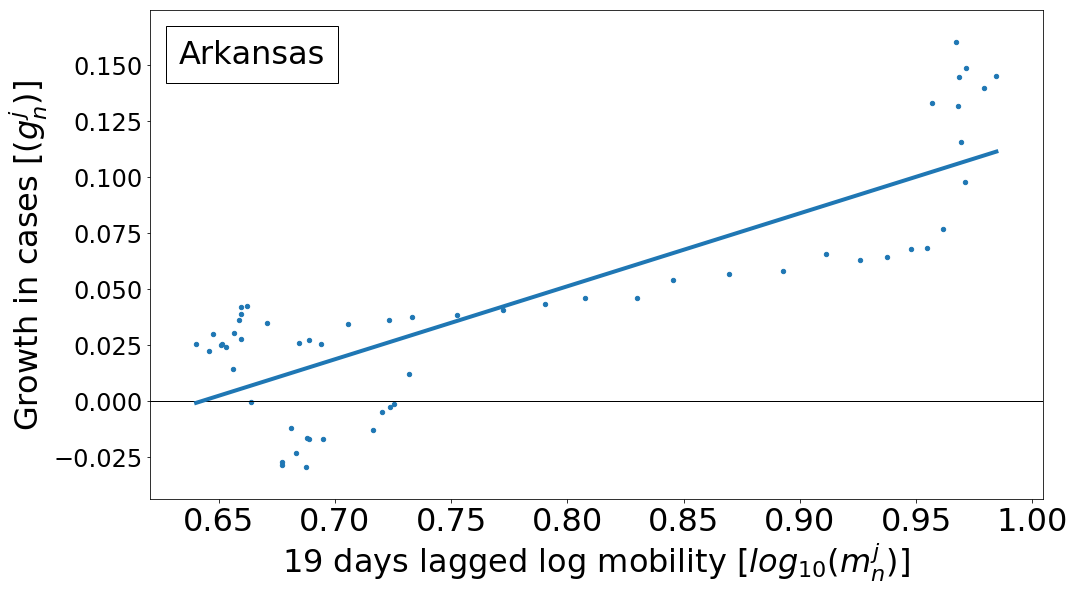

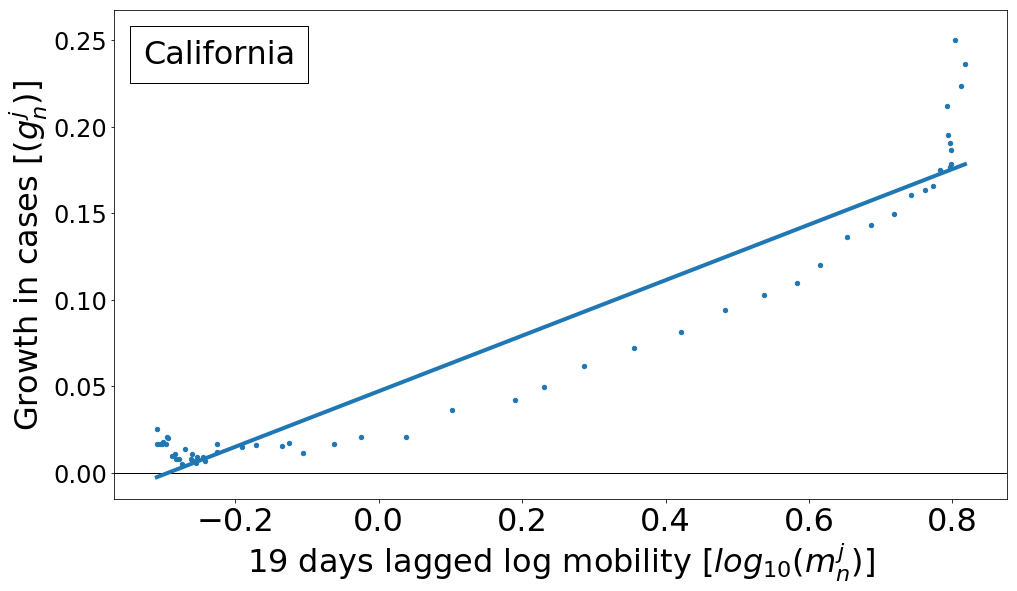

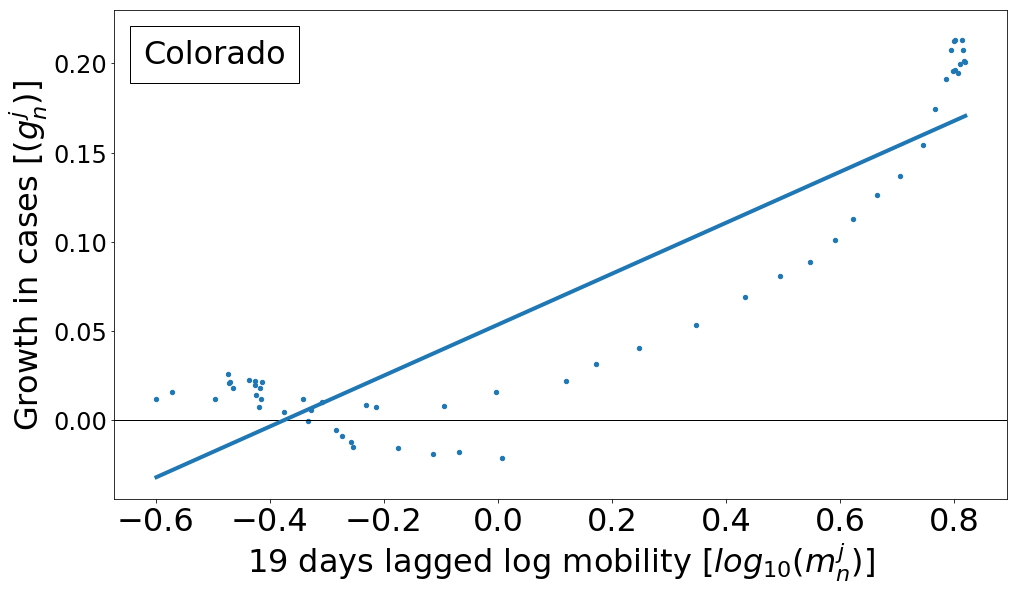

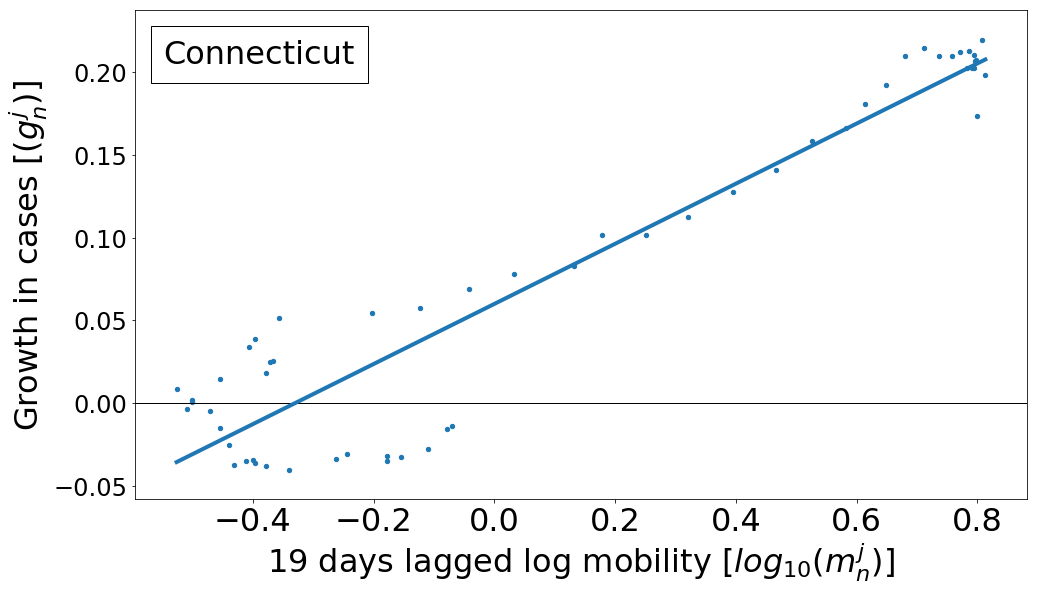

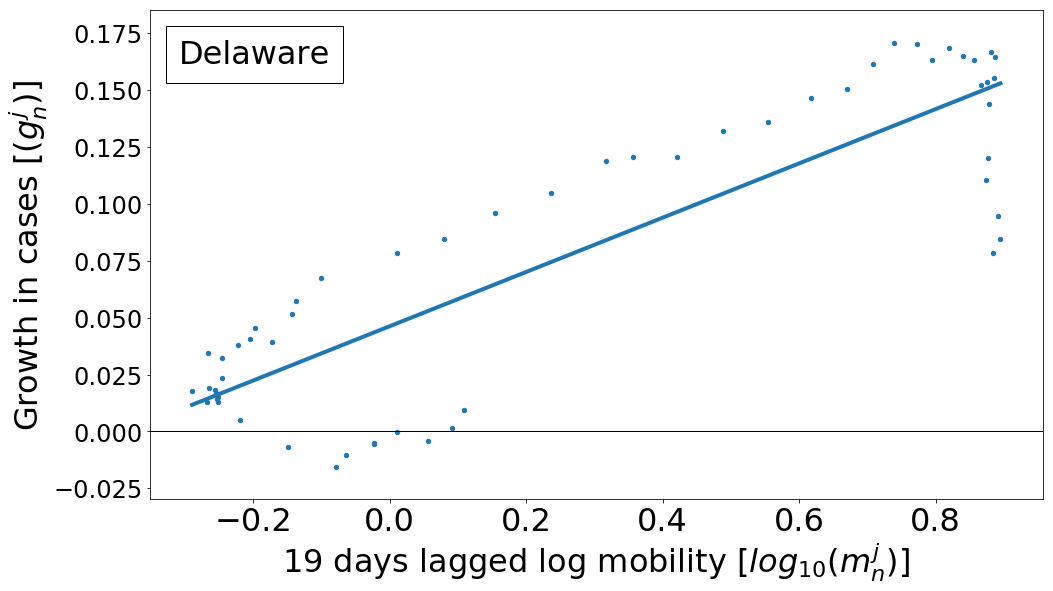

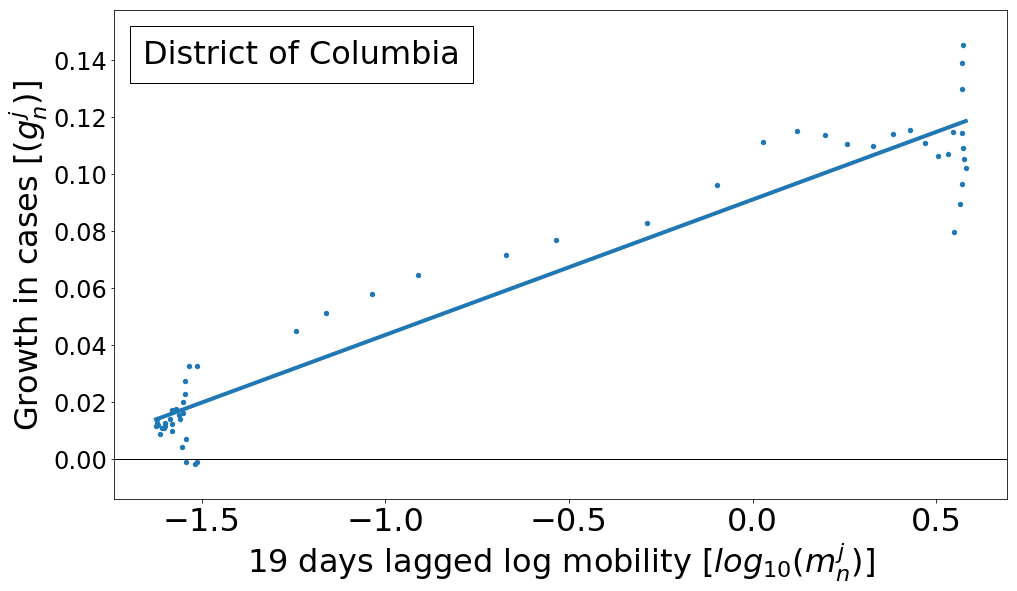

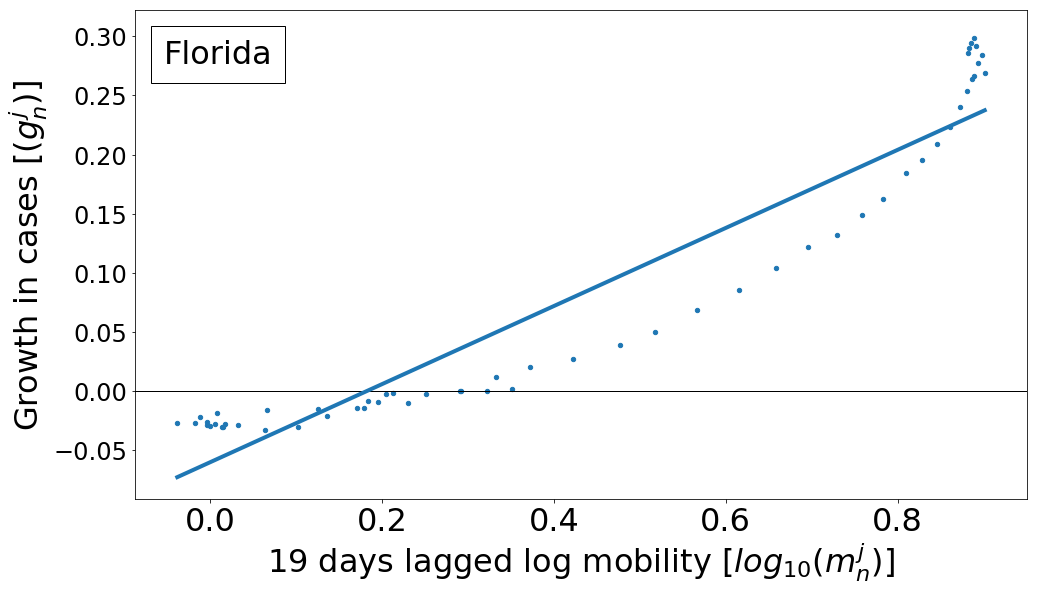

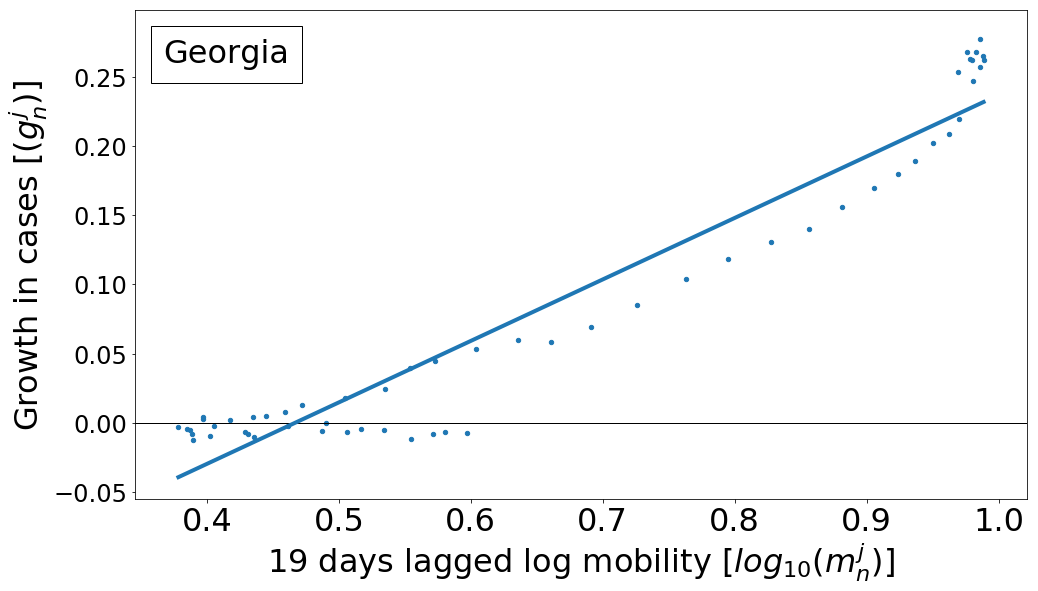

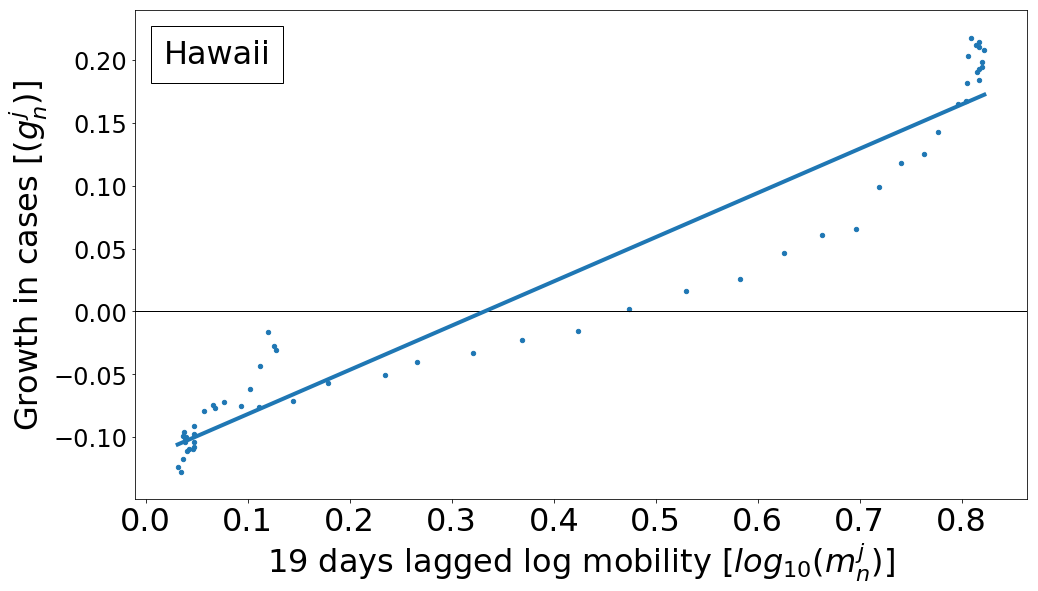

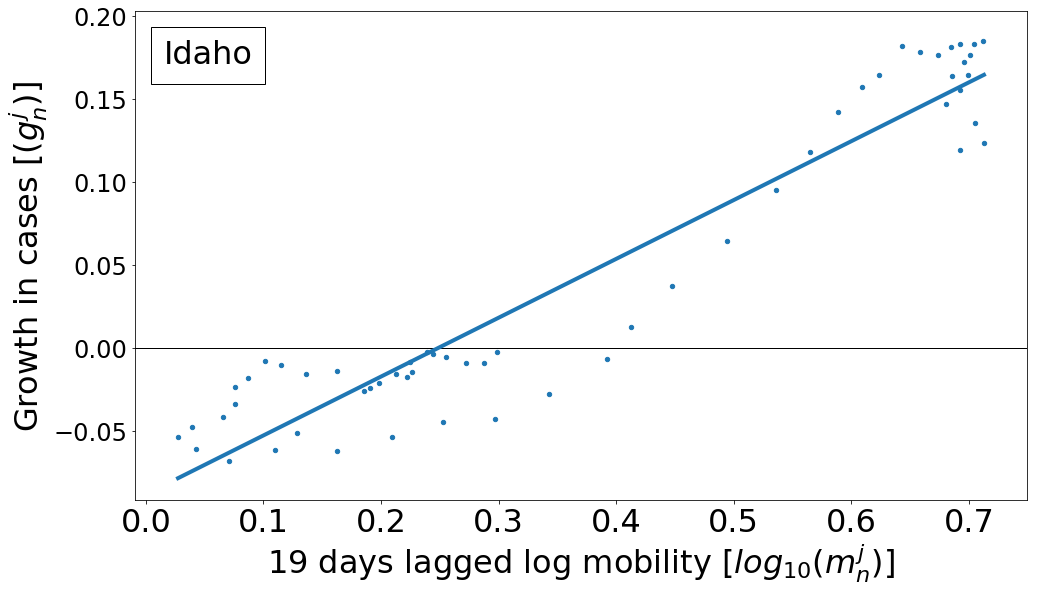

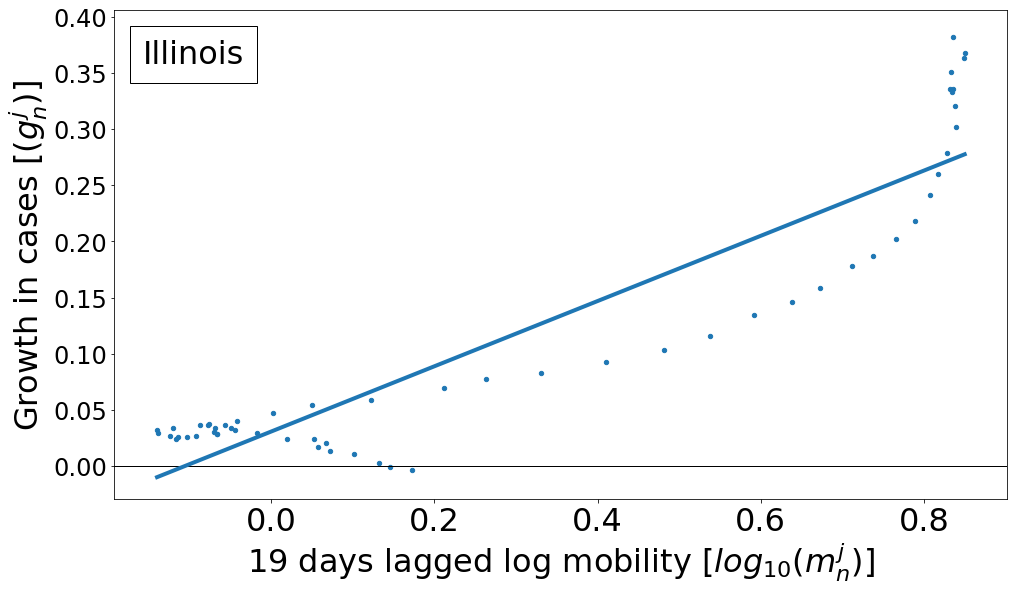

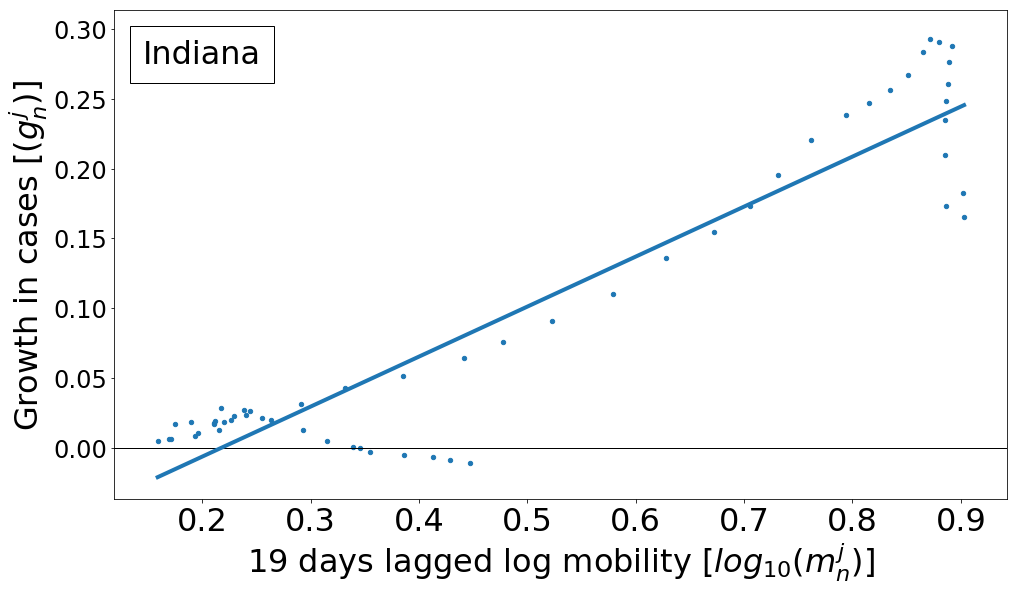

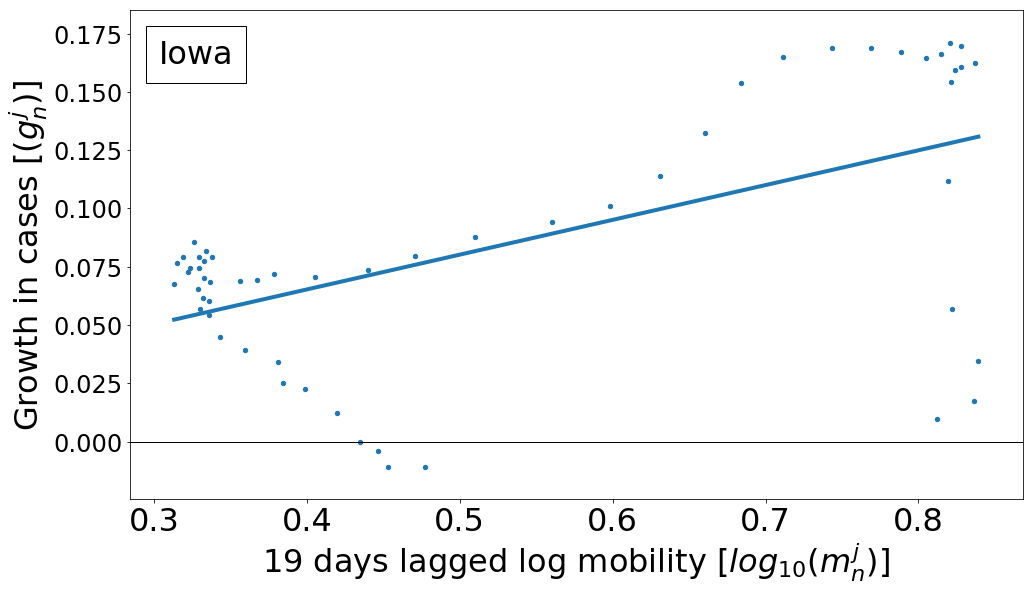

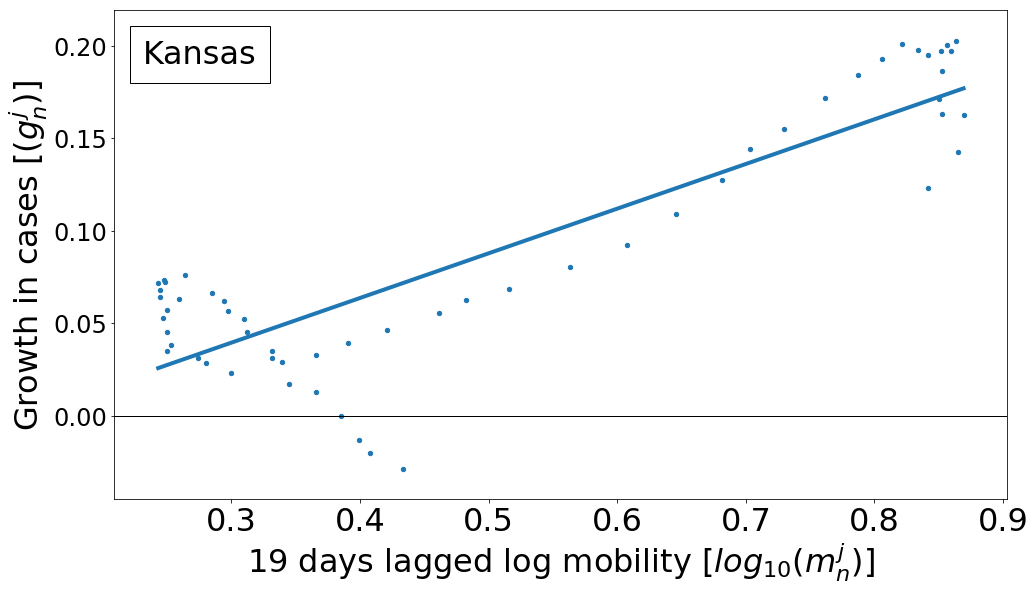

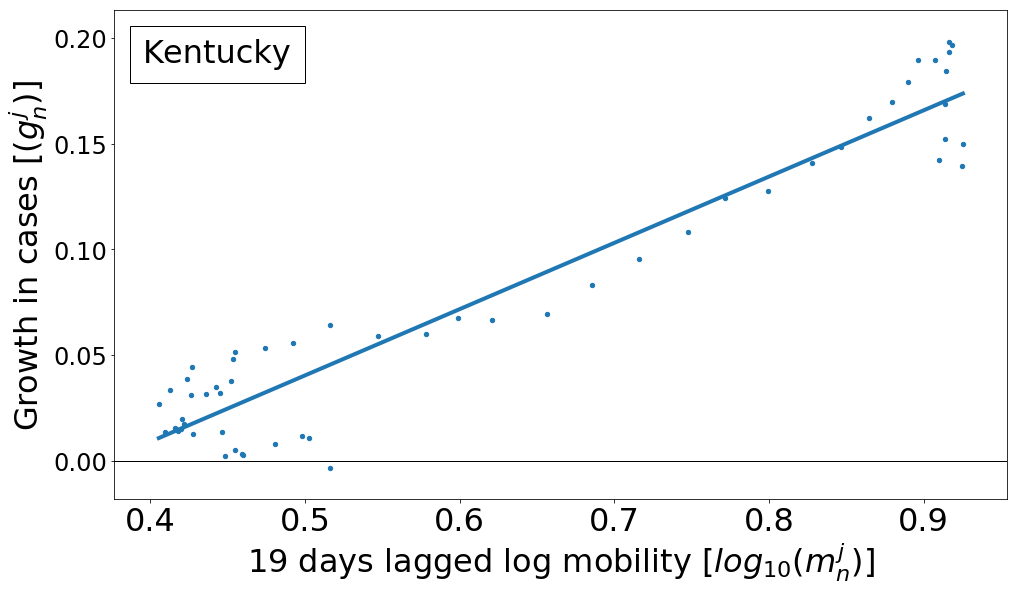

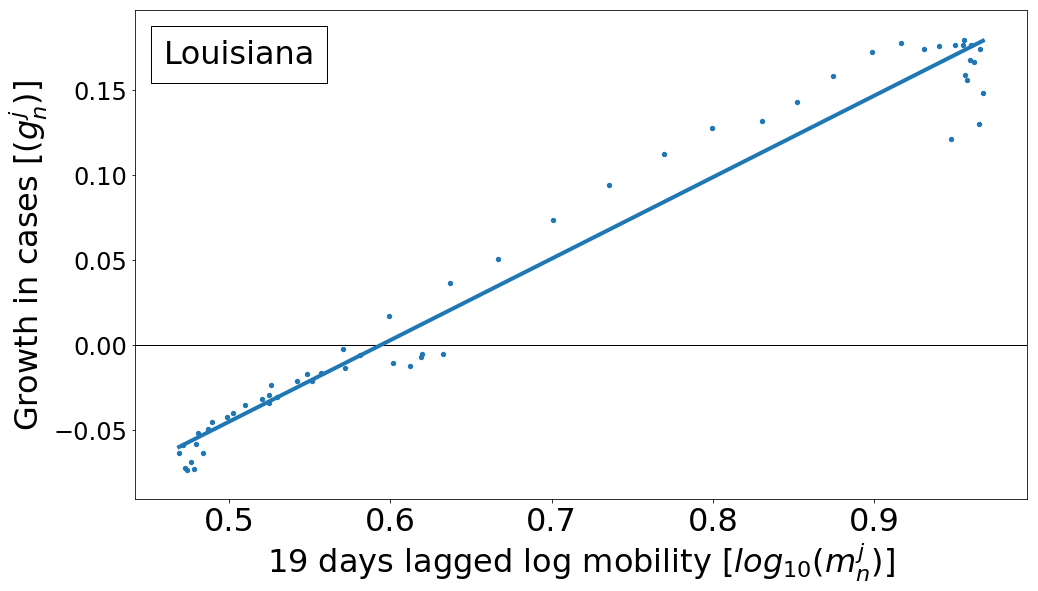

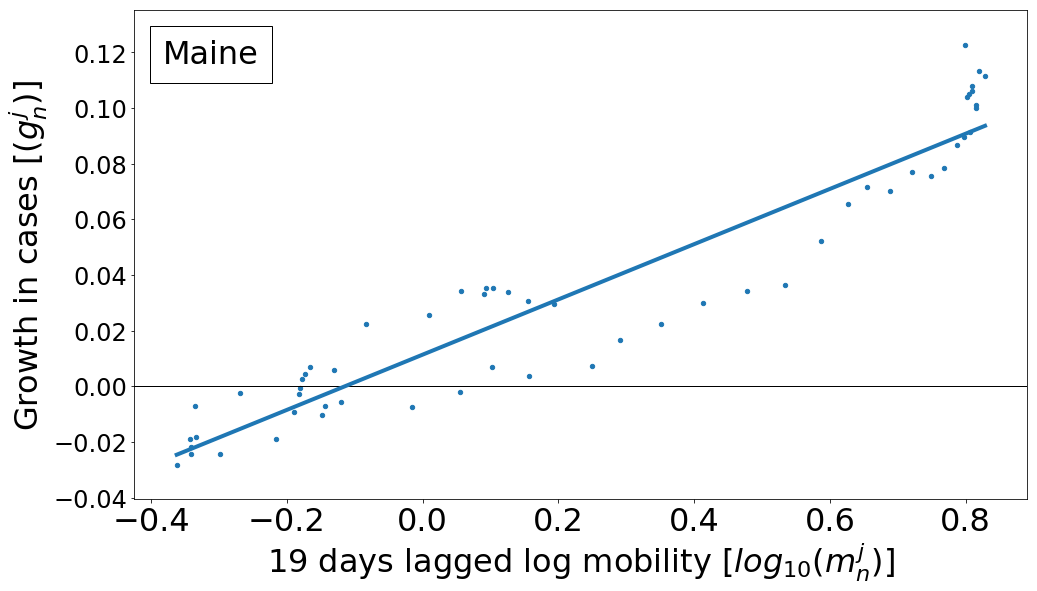

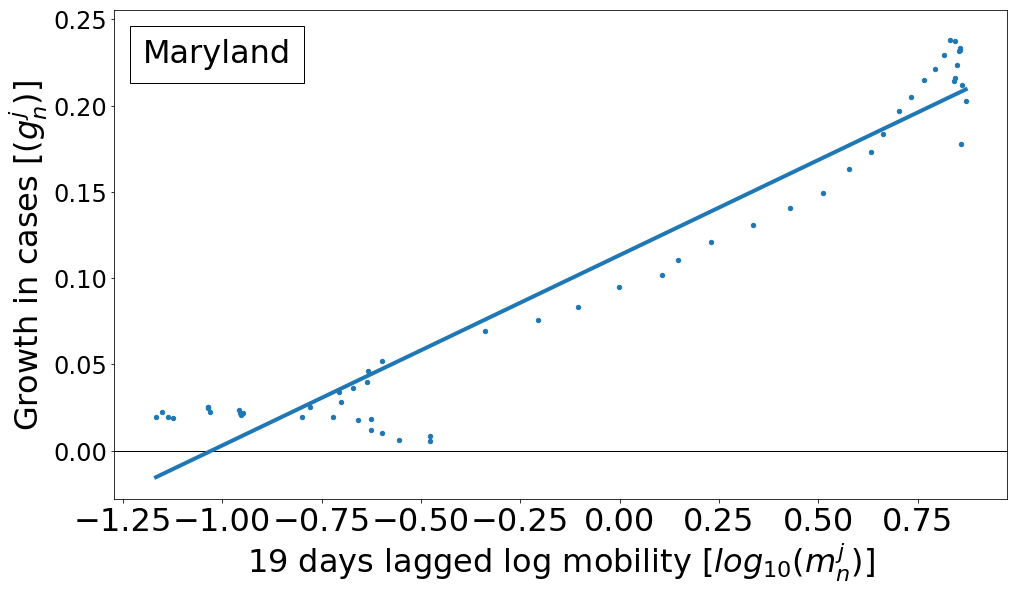

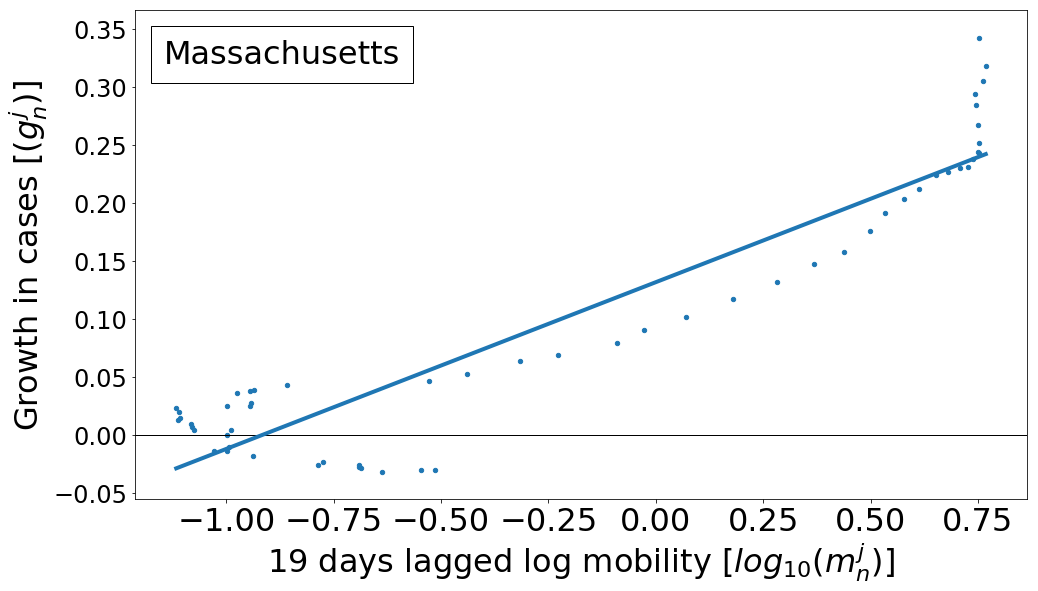

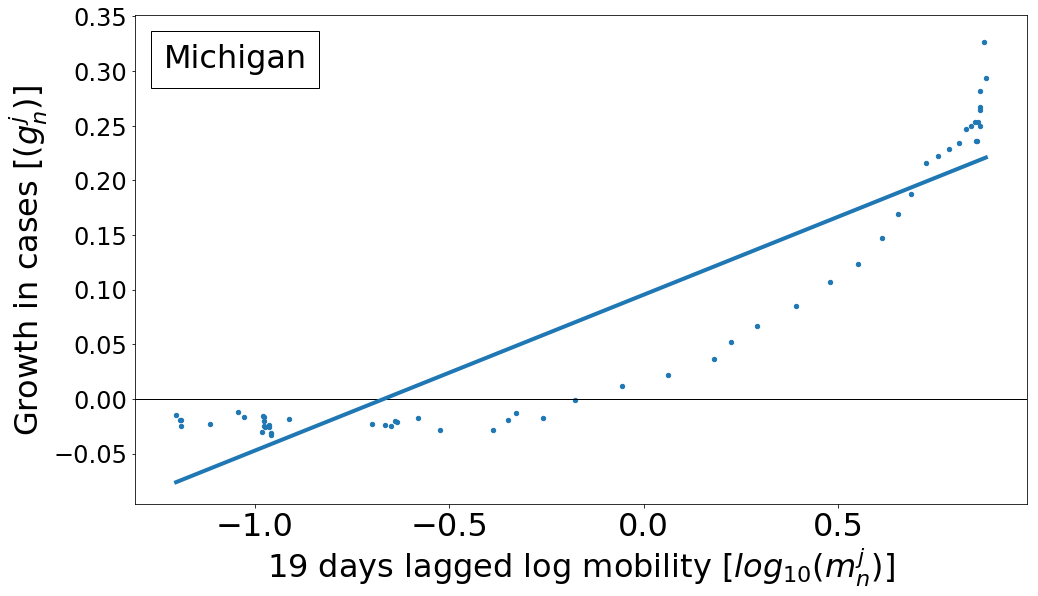

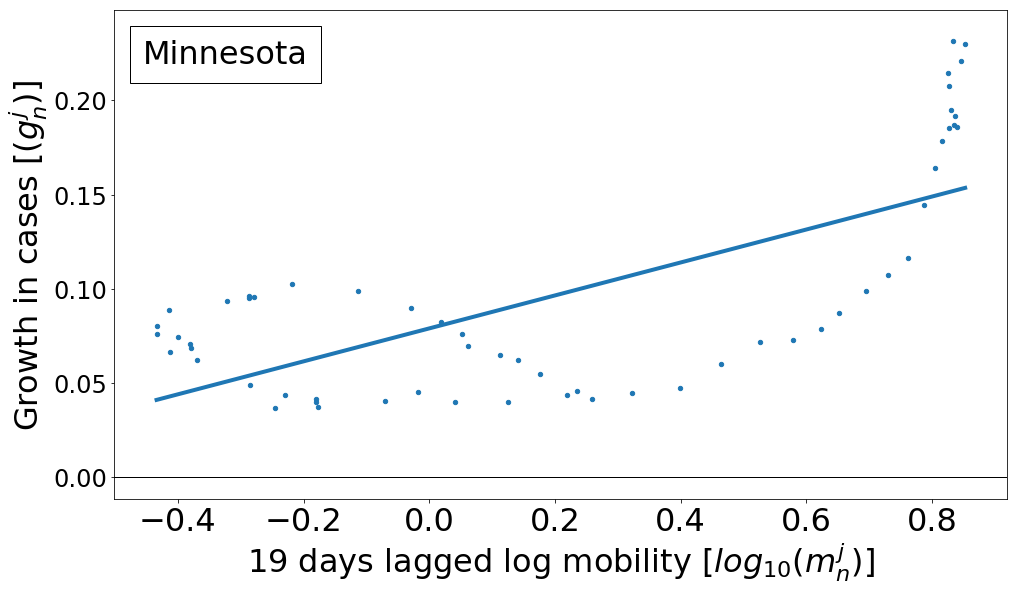

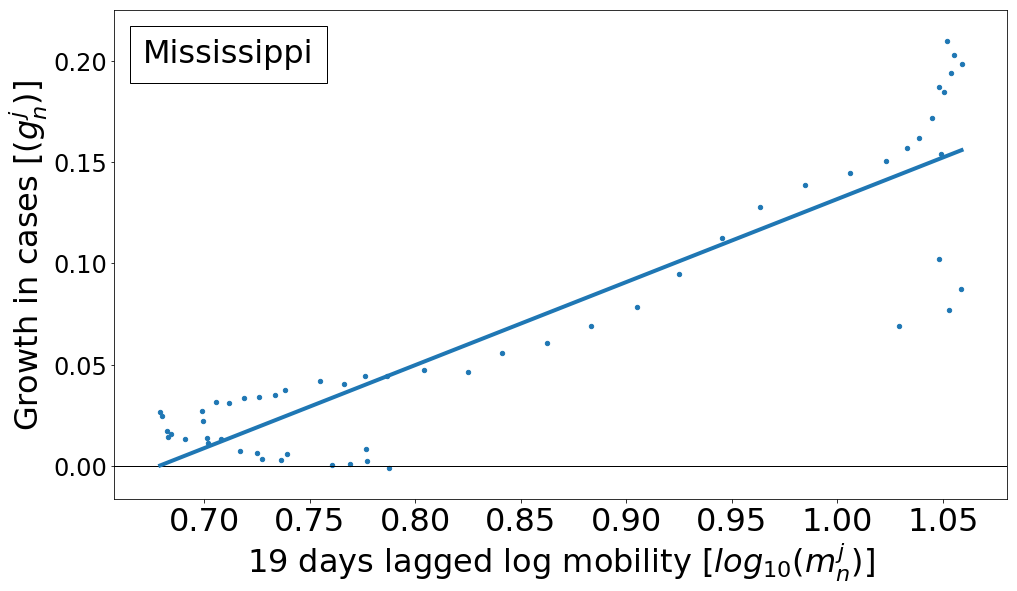

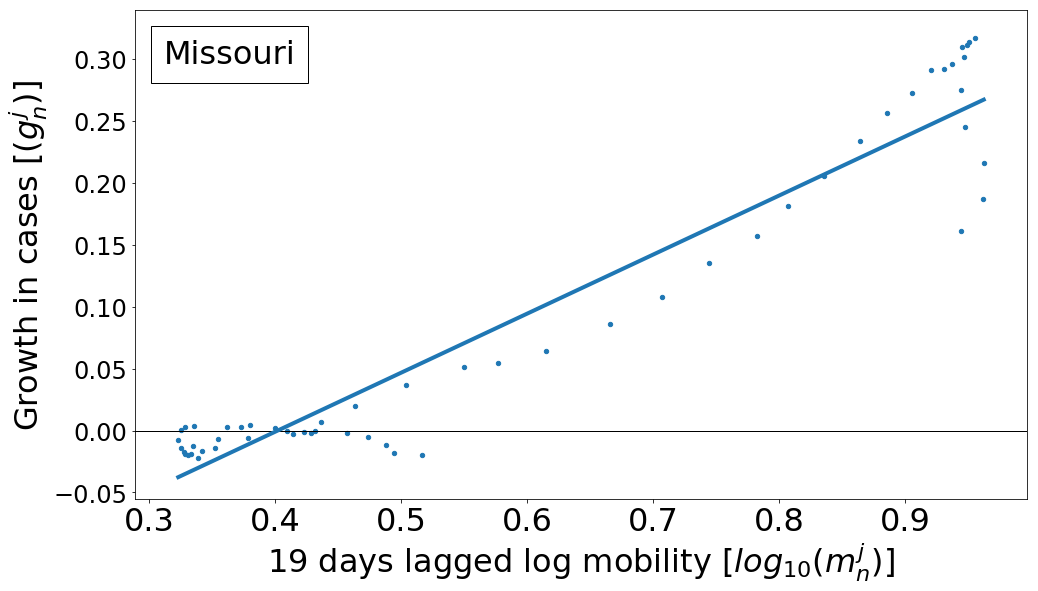

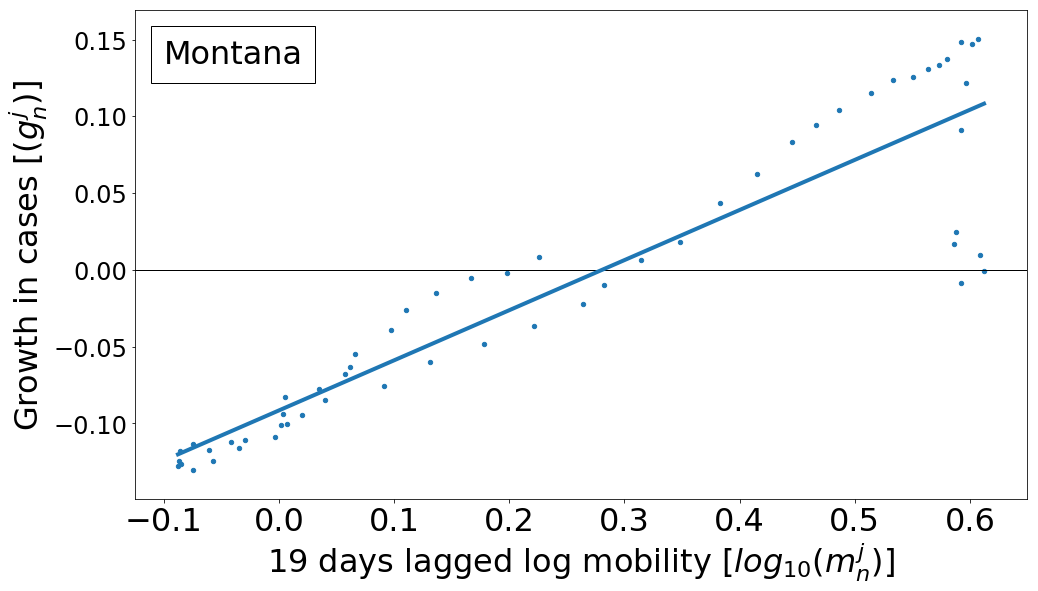

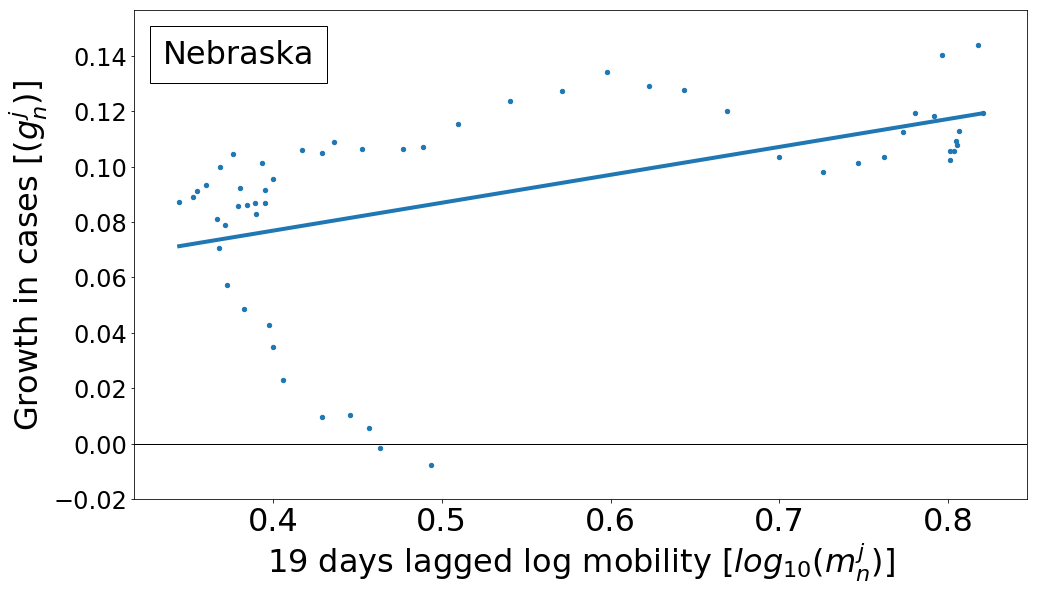

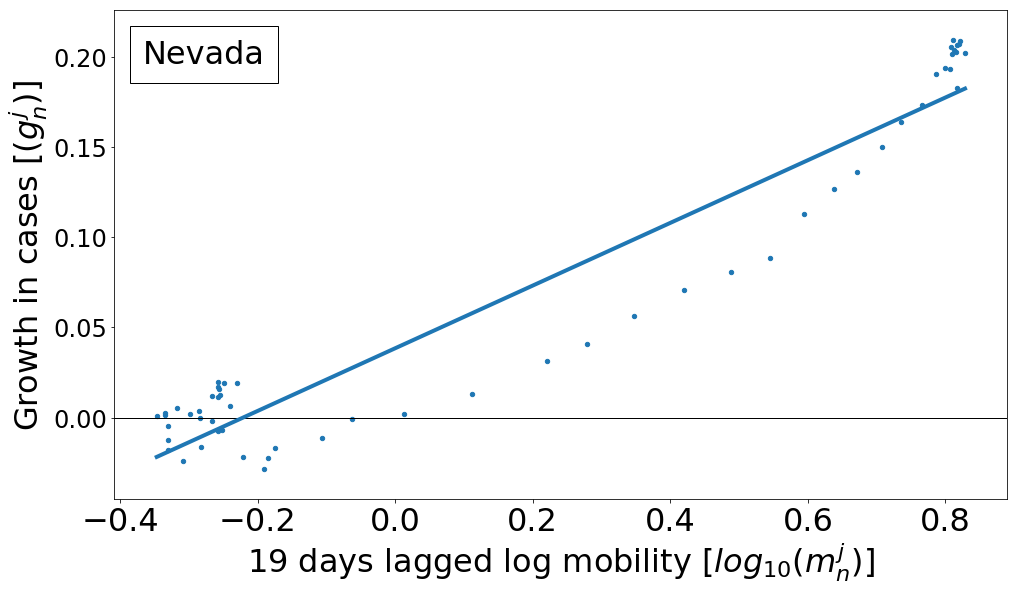

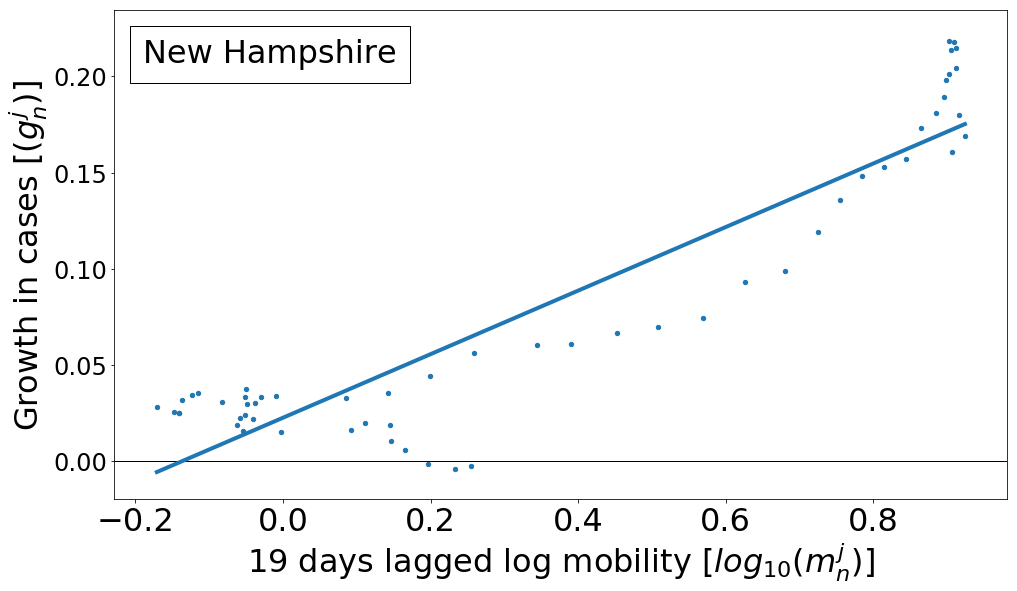

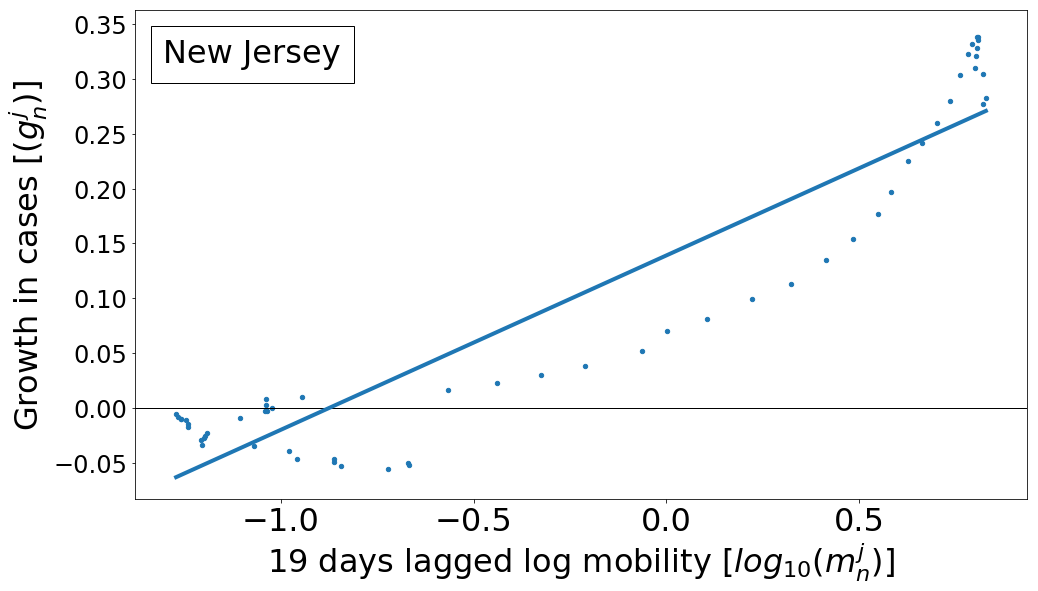

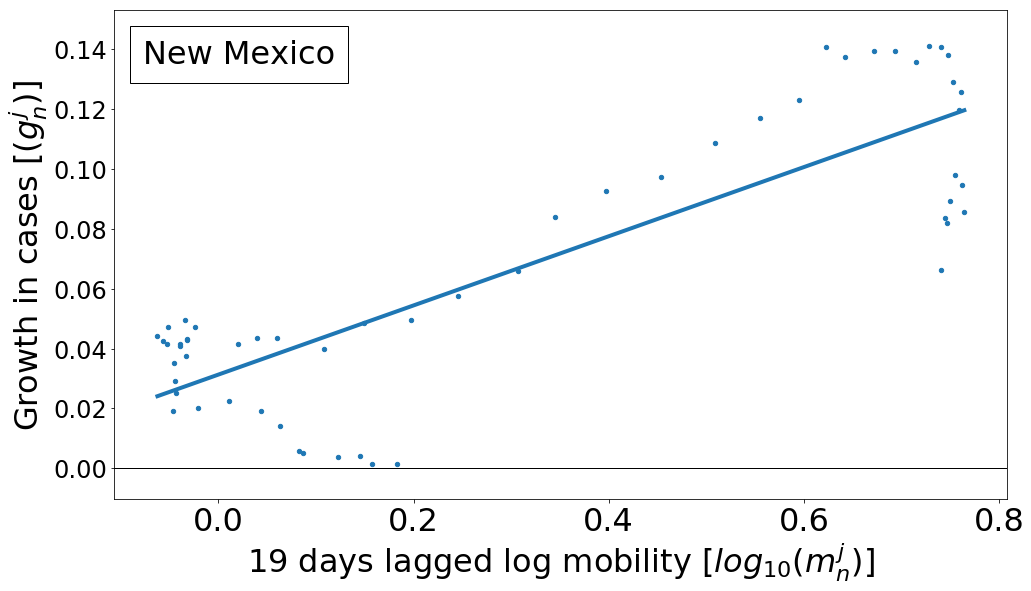

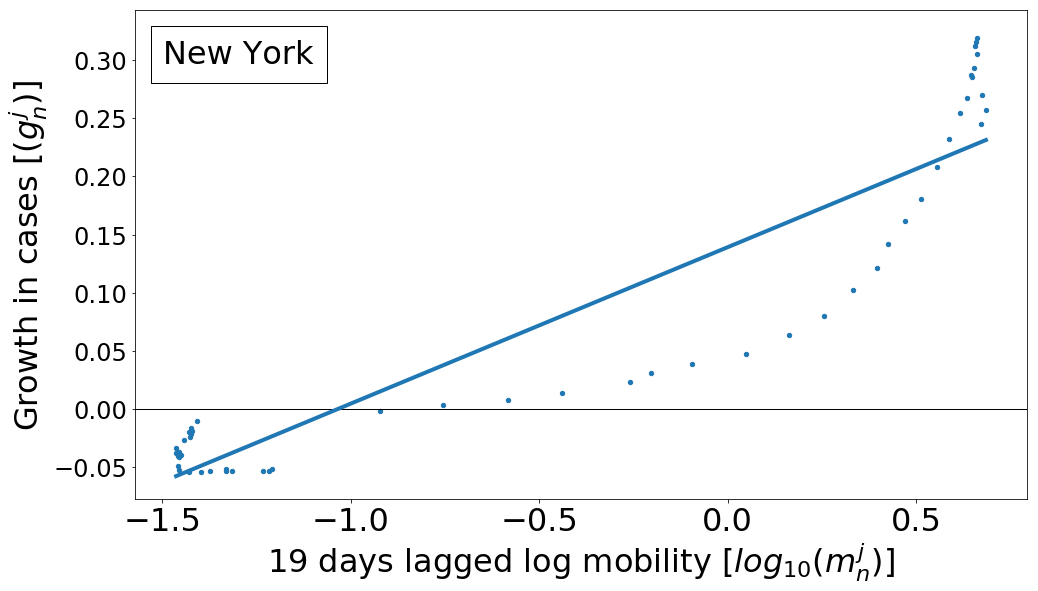

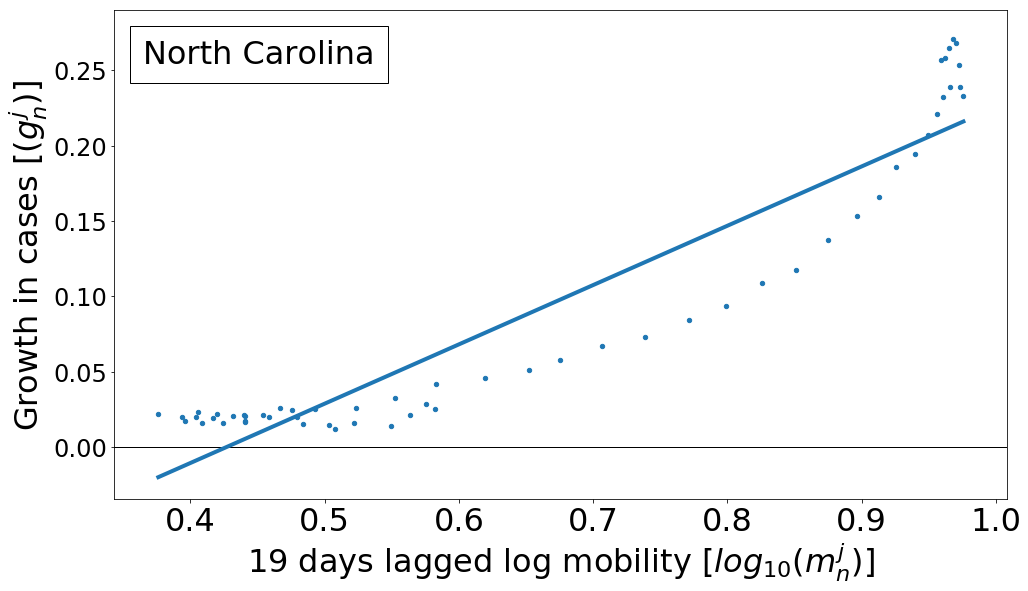

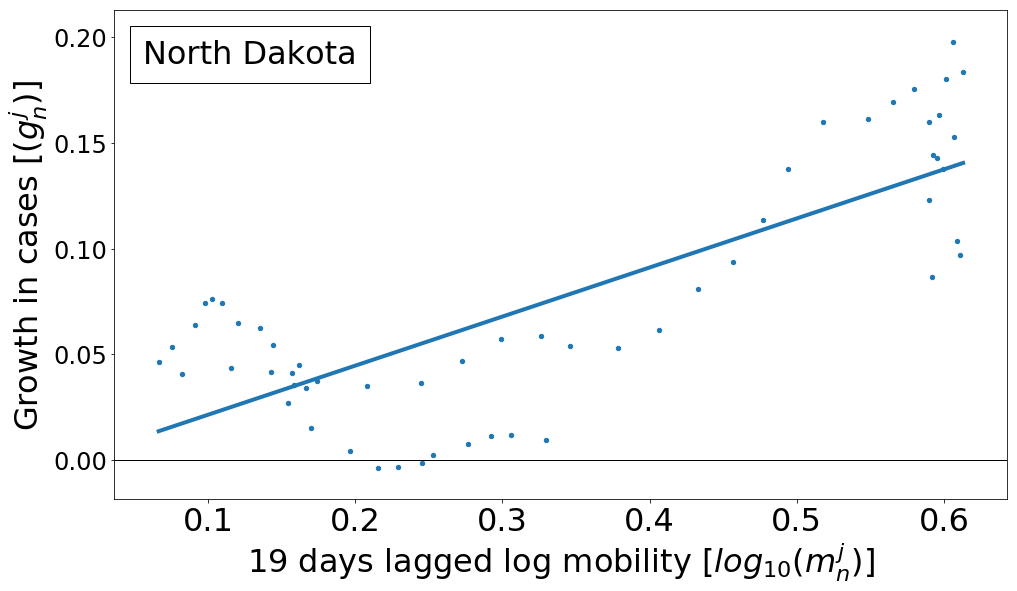

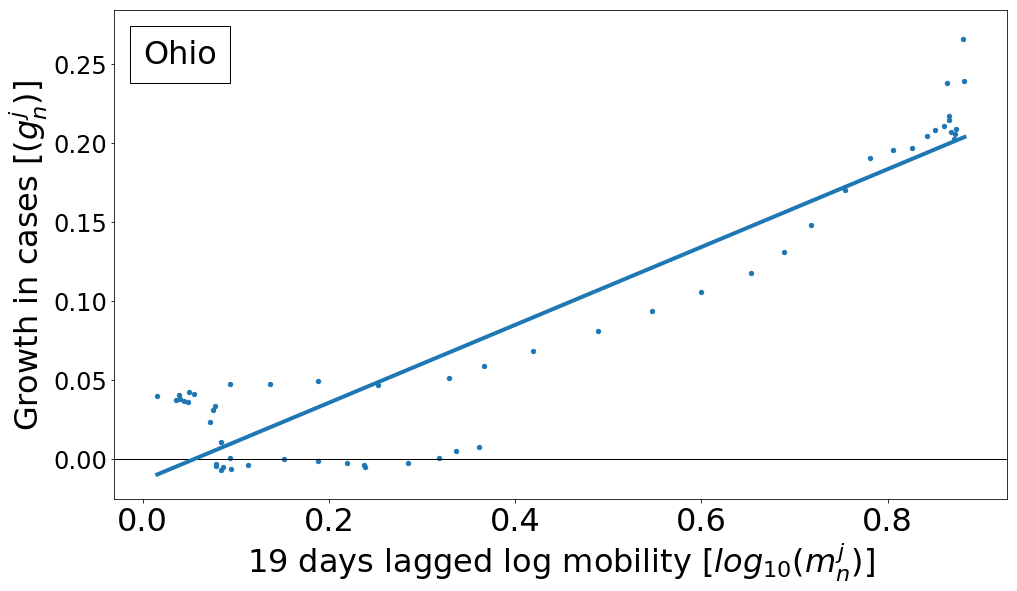

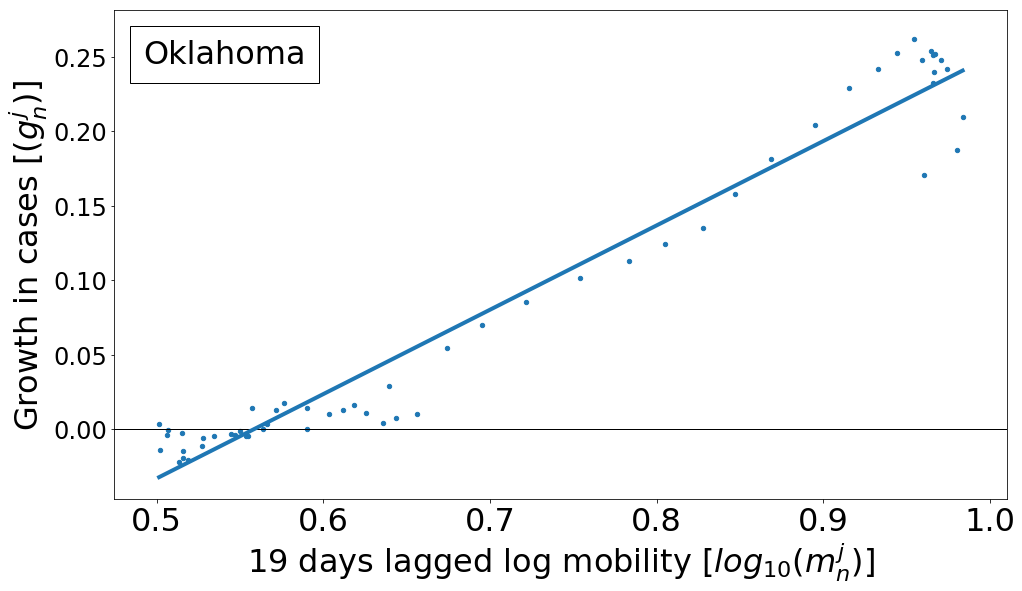

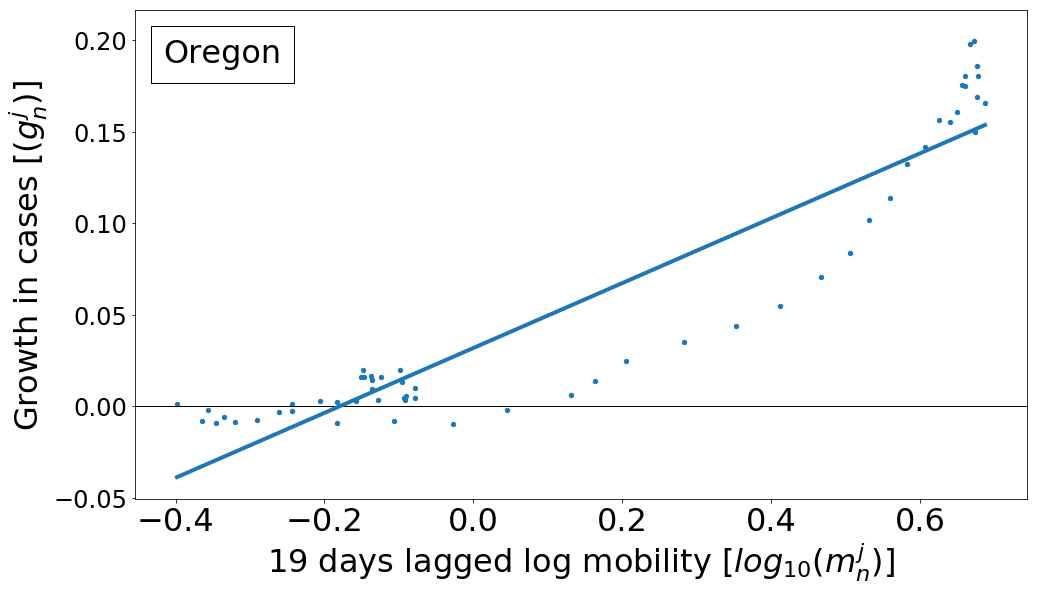

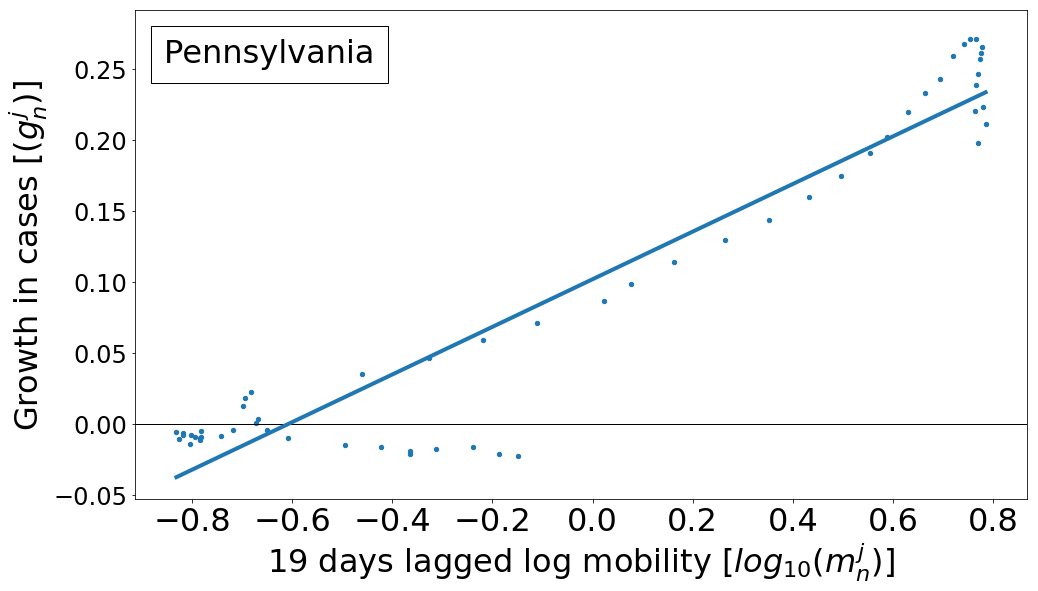

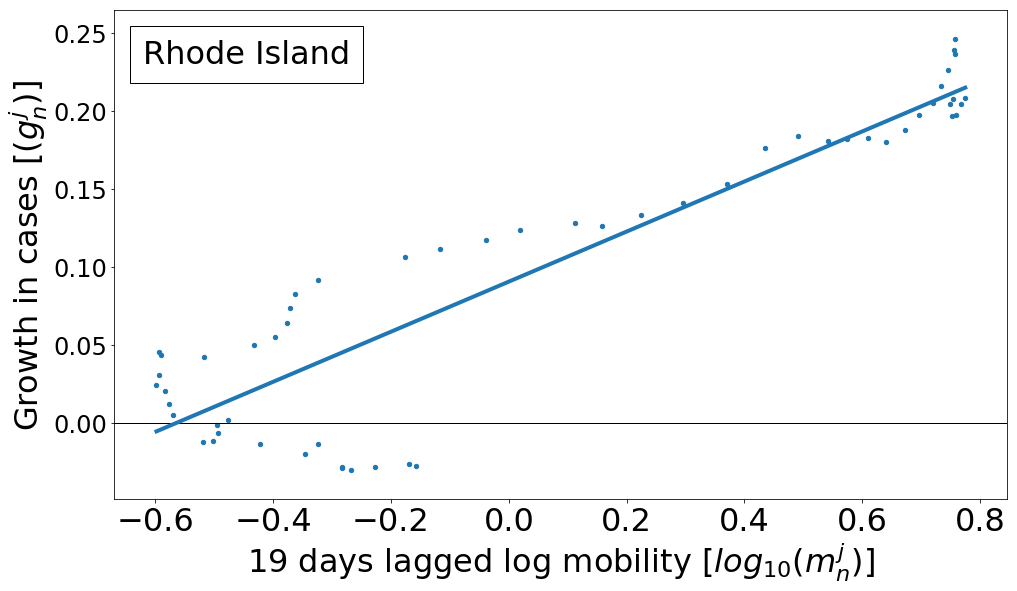

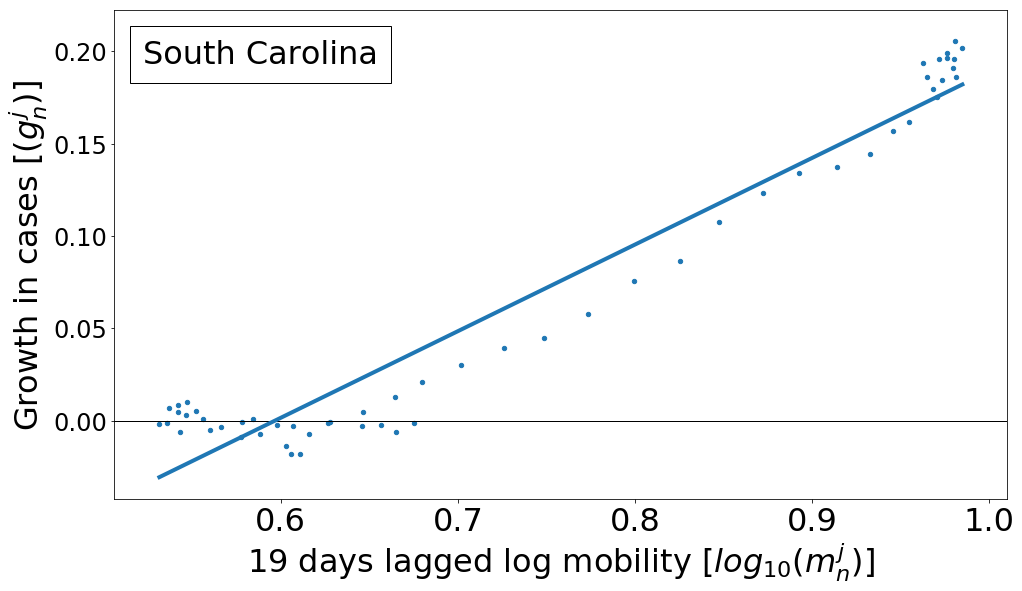

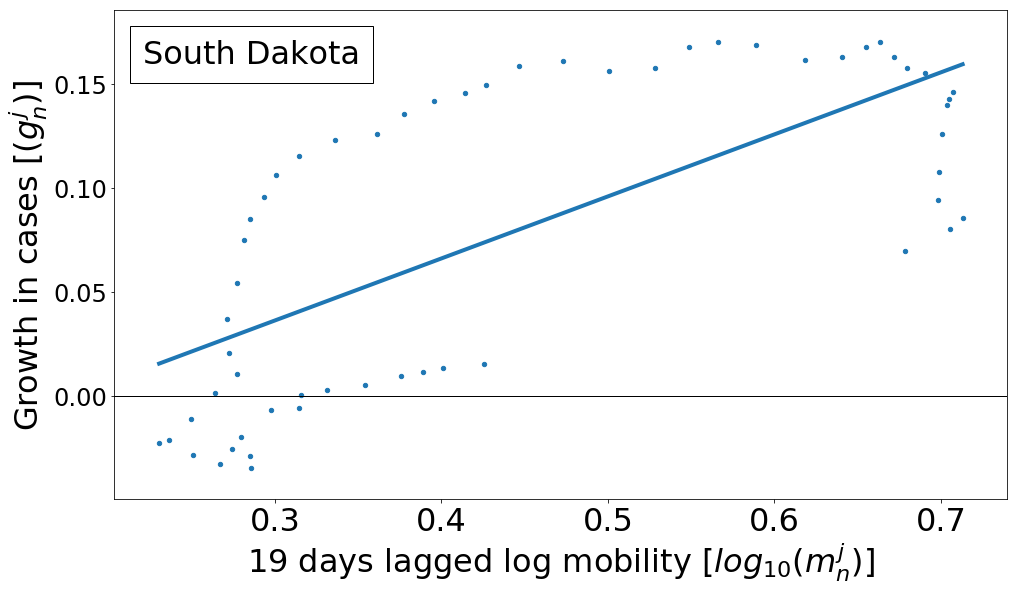

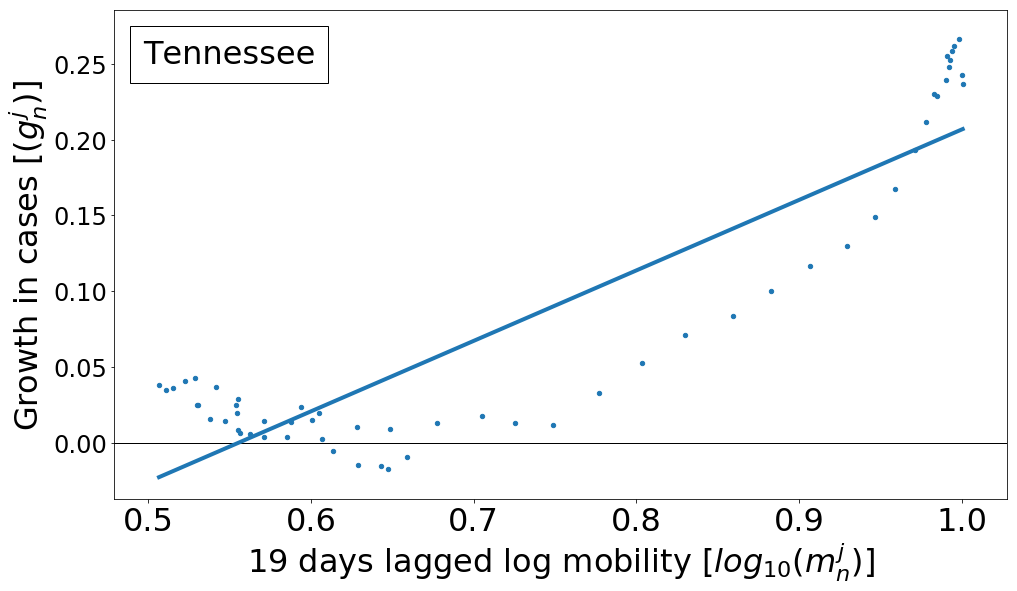

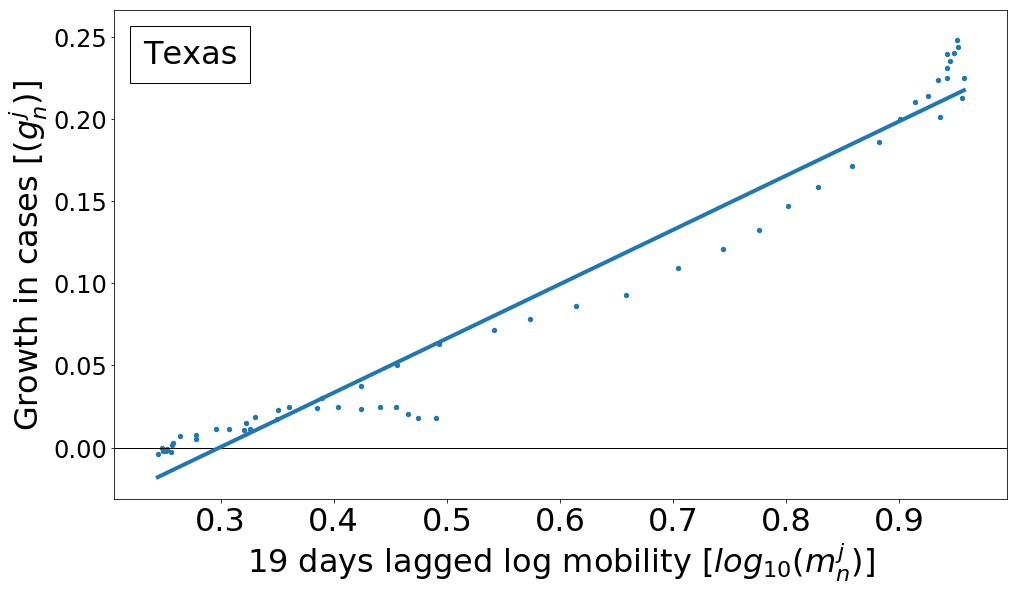

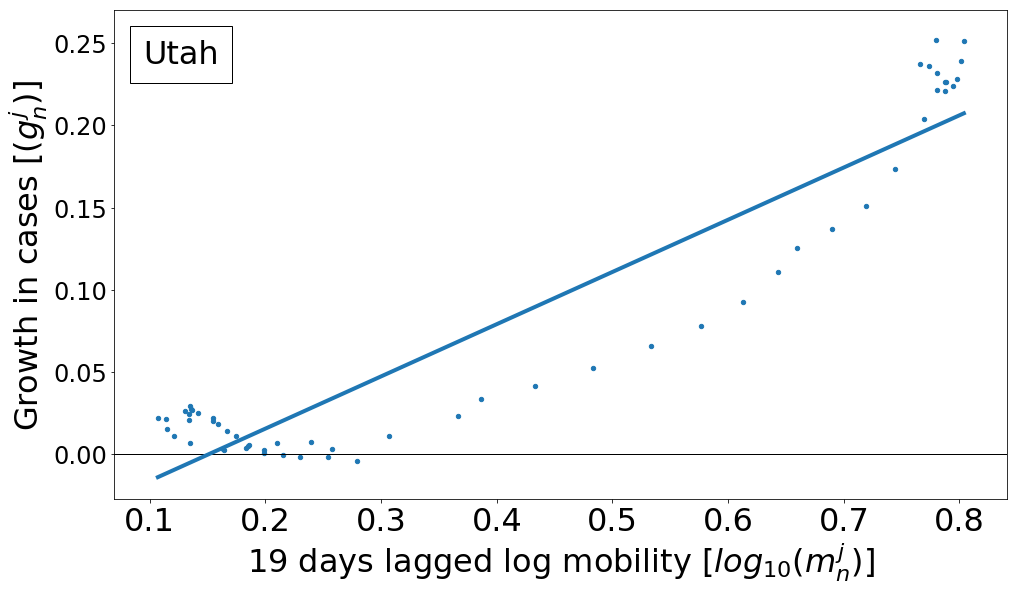

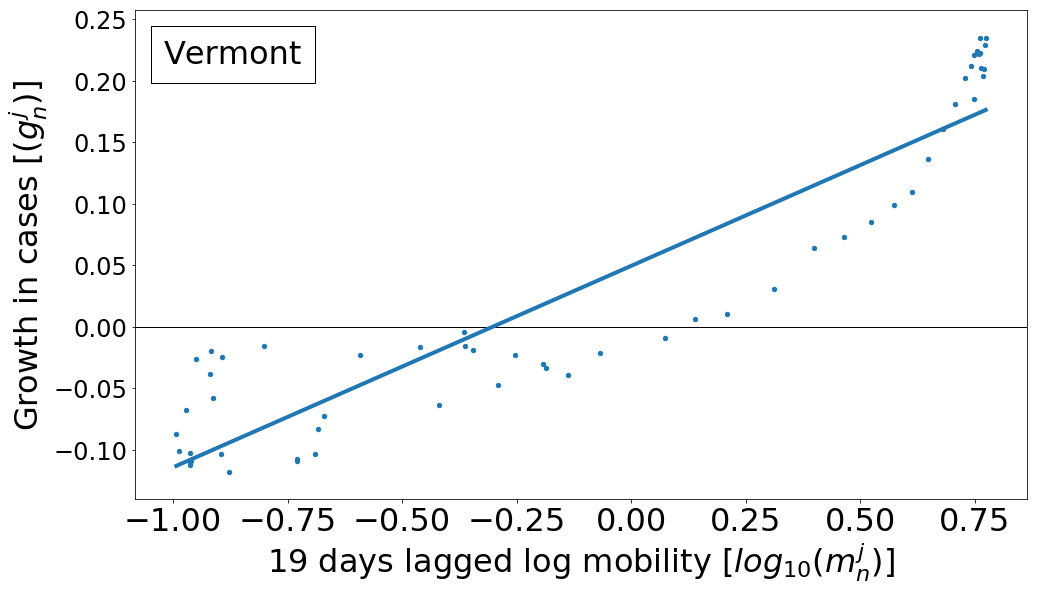

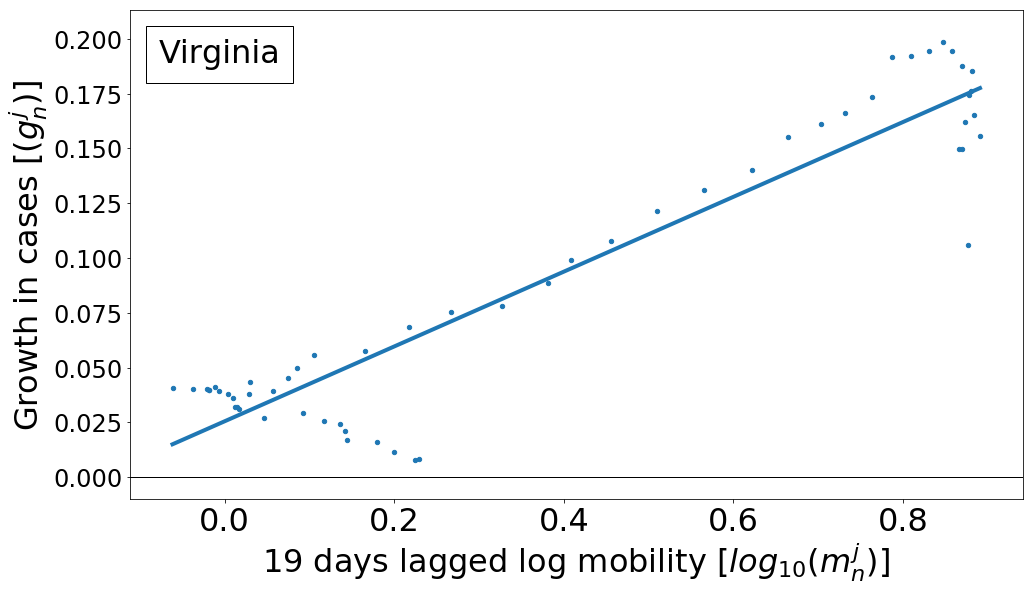

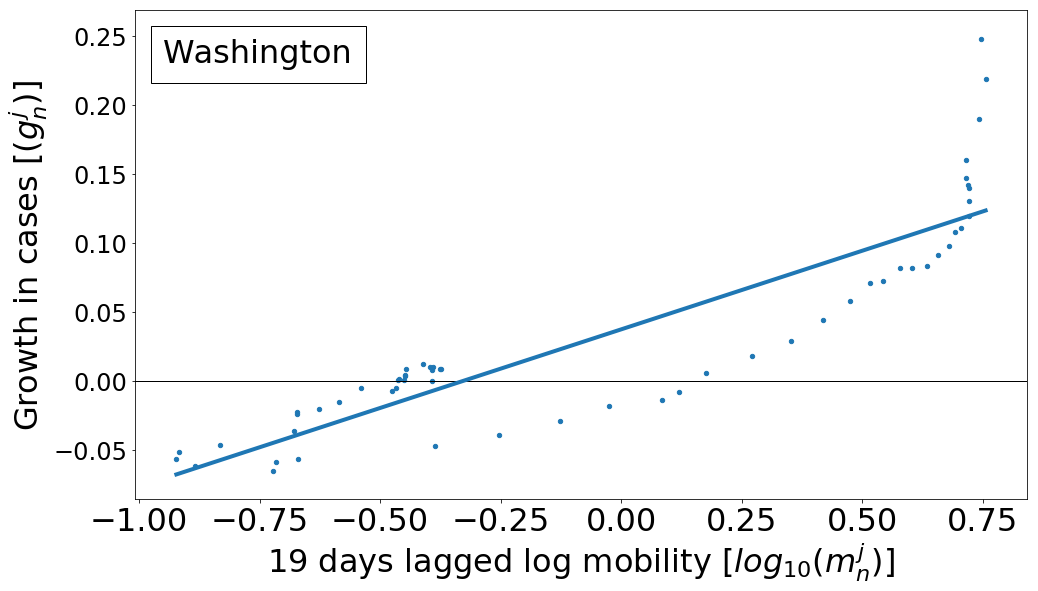

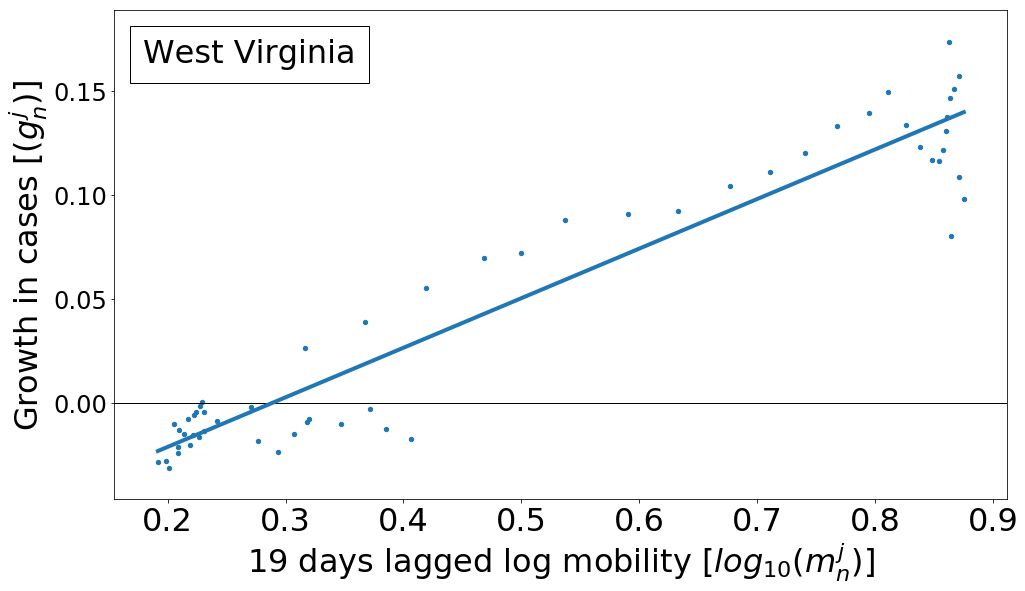

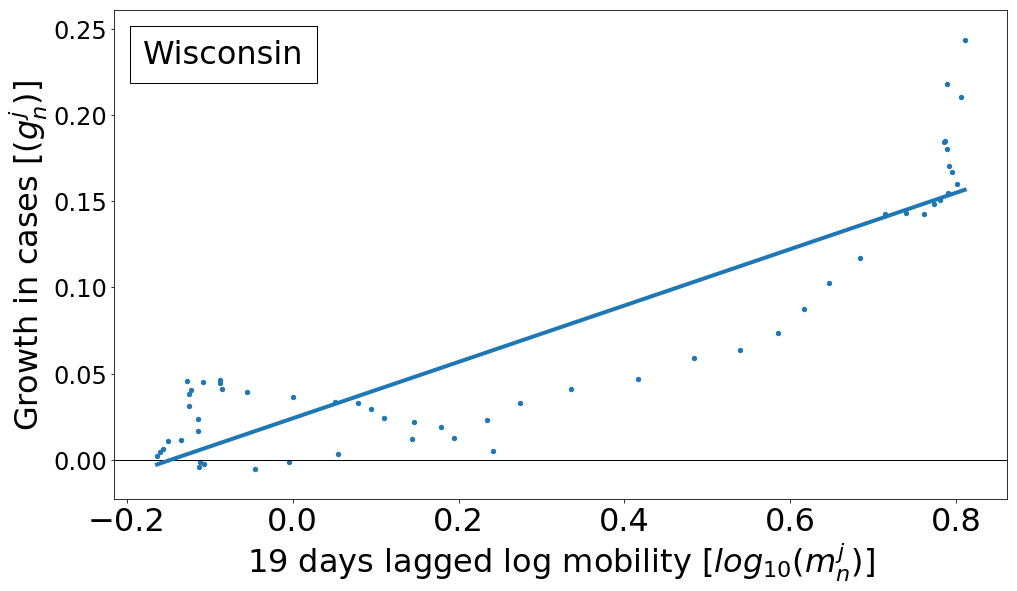

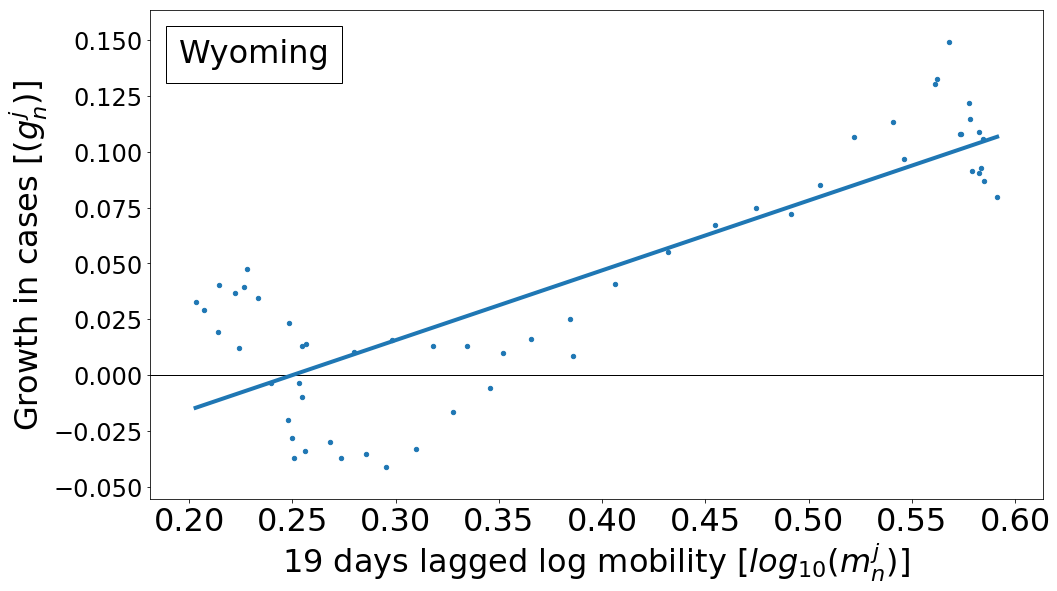

R2         b0         b1    pairs_id  x-intercept
count  51.000000  51.000000  51.000000   51.000000    51.000000
mean    0.825882  -0.036393   0.251696  146.000000    -0.078753
std     0.152081   0.125936   0.128726   14.866069     0.533259
min     0.230000  -0.315901   0.047489  121.000000    -1.917444
25%     0.805000  -0.095118   0.150416  133.500000    -0.344757
50%     0.870000   0.005630   0.232467  146.000000    -0.037754
75%     0.910000   0.048383   0.330158  158.500000     0.293758
max     0.970000   0.139144   0.565860  171.000000     0.678600

In [18]:
# Shutdown Period LogMobility

dt_cutoff_max = datetime(2020, 4, 30, tzinfo=pytz.utc)
df_plot = df_lagged[df_lagged.index<=dt_cutoff_max]
df_summary = pandas.DataFrame()

for pairs_id in df_region.sort_values(by='State')['pairs_id'].values:
    row = {}
    row['pairs_id'] = pairs_id
    row['State'] = df_region[df_region['pairs_id']==pairs_id]['State'].values[0]

    df_single = df_plot[pairs_id]
    
    if len(df_single)>0:
        plt.figure(figsize=(16,9))
        ax = plt.subplot(1,1,1)
        plt.scatter(df_single['LogMobility'], df_single['GrowthCases'], s=19)
        plt.axhline(color='k', lw=1)
        #plt.axvline(color='k', lw=1)

        title_string = df_region[df_region['pairs_id']==pairs_id]['State'].values[0]

        plt.xlabel(str(cases_lag_measured) + ' days lagged log mobility $[log_{10}(m^j_n)]$', size=32)
        plt.ylabel('Growth in cases $[(g^j_n)]$', size=32)
        plt.xticks(fontsize=32)
        plt.yticks(fontsize=24)

        try:
            # Linear Regression
            X = df_single['LogMobility']
            X = sm.add_constant(X) #intercept
            y = df_single['GrowthCases']
            model = sm.OLS(y, X)
            results = model.fit()
            #print('Parameters: ', results.params)
            #print('R2: ', results.rsquared)
            b0 = results.params.const
            b1 = results.params.LogMobility
            
            row['b0'] = b0
            row['b1'] = b1
            row['x-intercept'] = -b0/b1
            row['R2'] = numpy.round(results.rsquared, 2)

            x1 = df_single['LogMobility'].min() #-1
            x2 = df_single['LogMobility'].max() #2.5
            plt.plot([x1, x2], [b1*x1+b0, b1*x2+b0], lw=4)

            #anchored_text = AnchoredText(str(numpy.round(b1, 3)) + 'x+' + str(numpy.round(b0, 3))+
            #                             '\nx-intercept '+str(numpy.round(-b0/b1, 2)), loc=2)
            #ax.add_artist(anchored_text)

            anchored_text = AnchoredText(title_string, loc=2, prop=dict(size=32))
            ax.add_artist(anchored_text)

        except: 
            pass

        plt.show()
        
    df_summary = df_summary.append(pandas.DataFrame(row, index=[0]))
df_summary.describe()


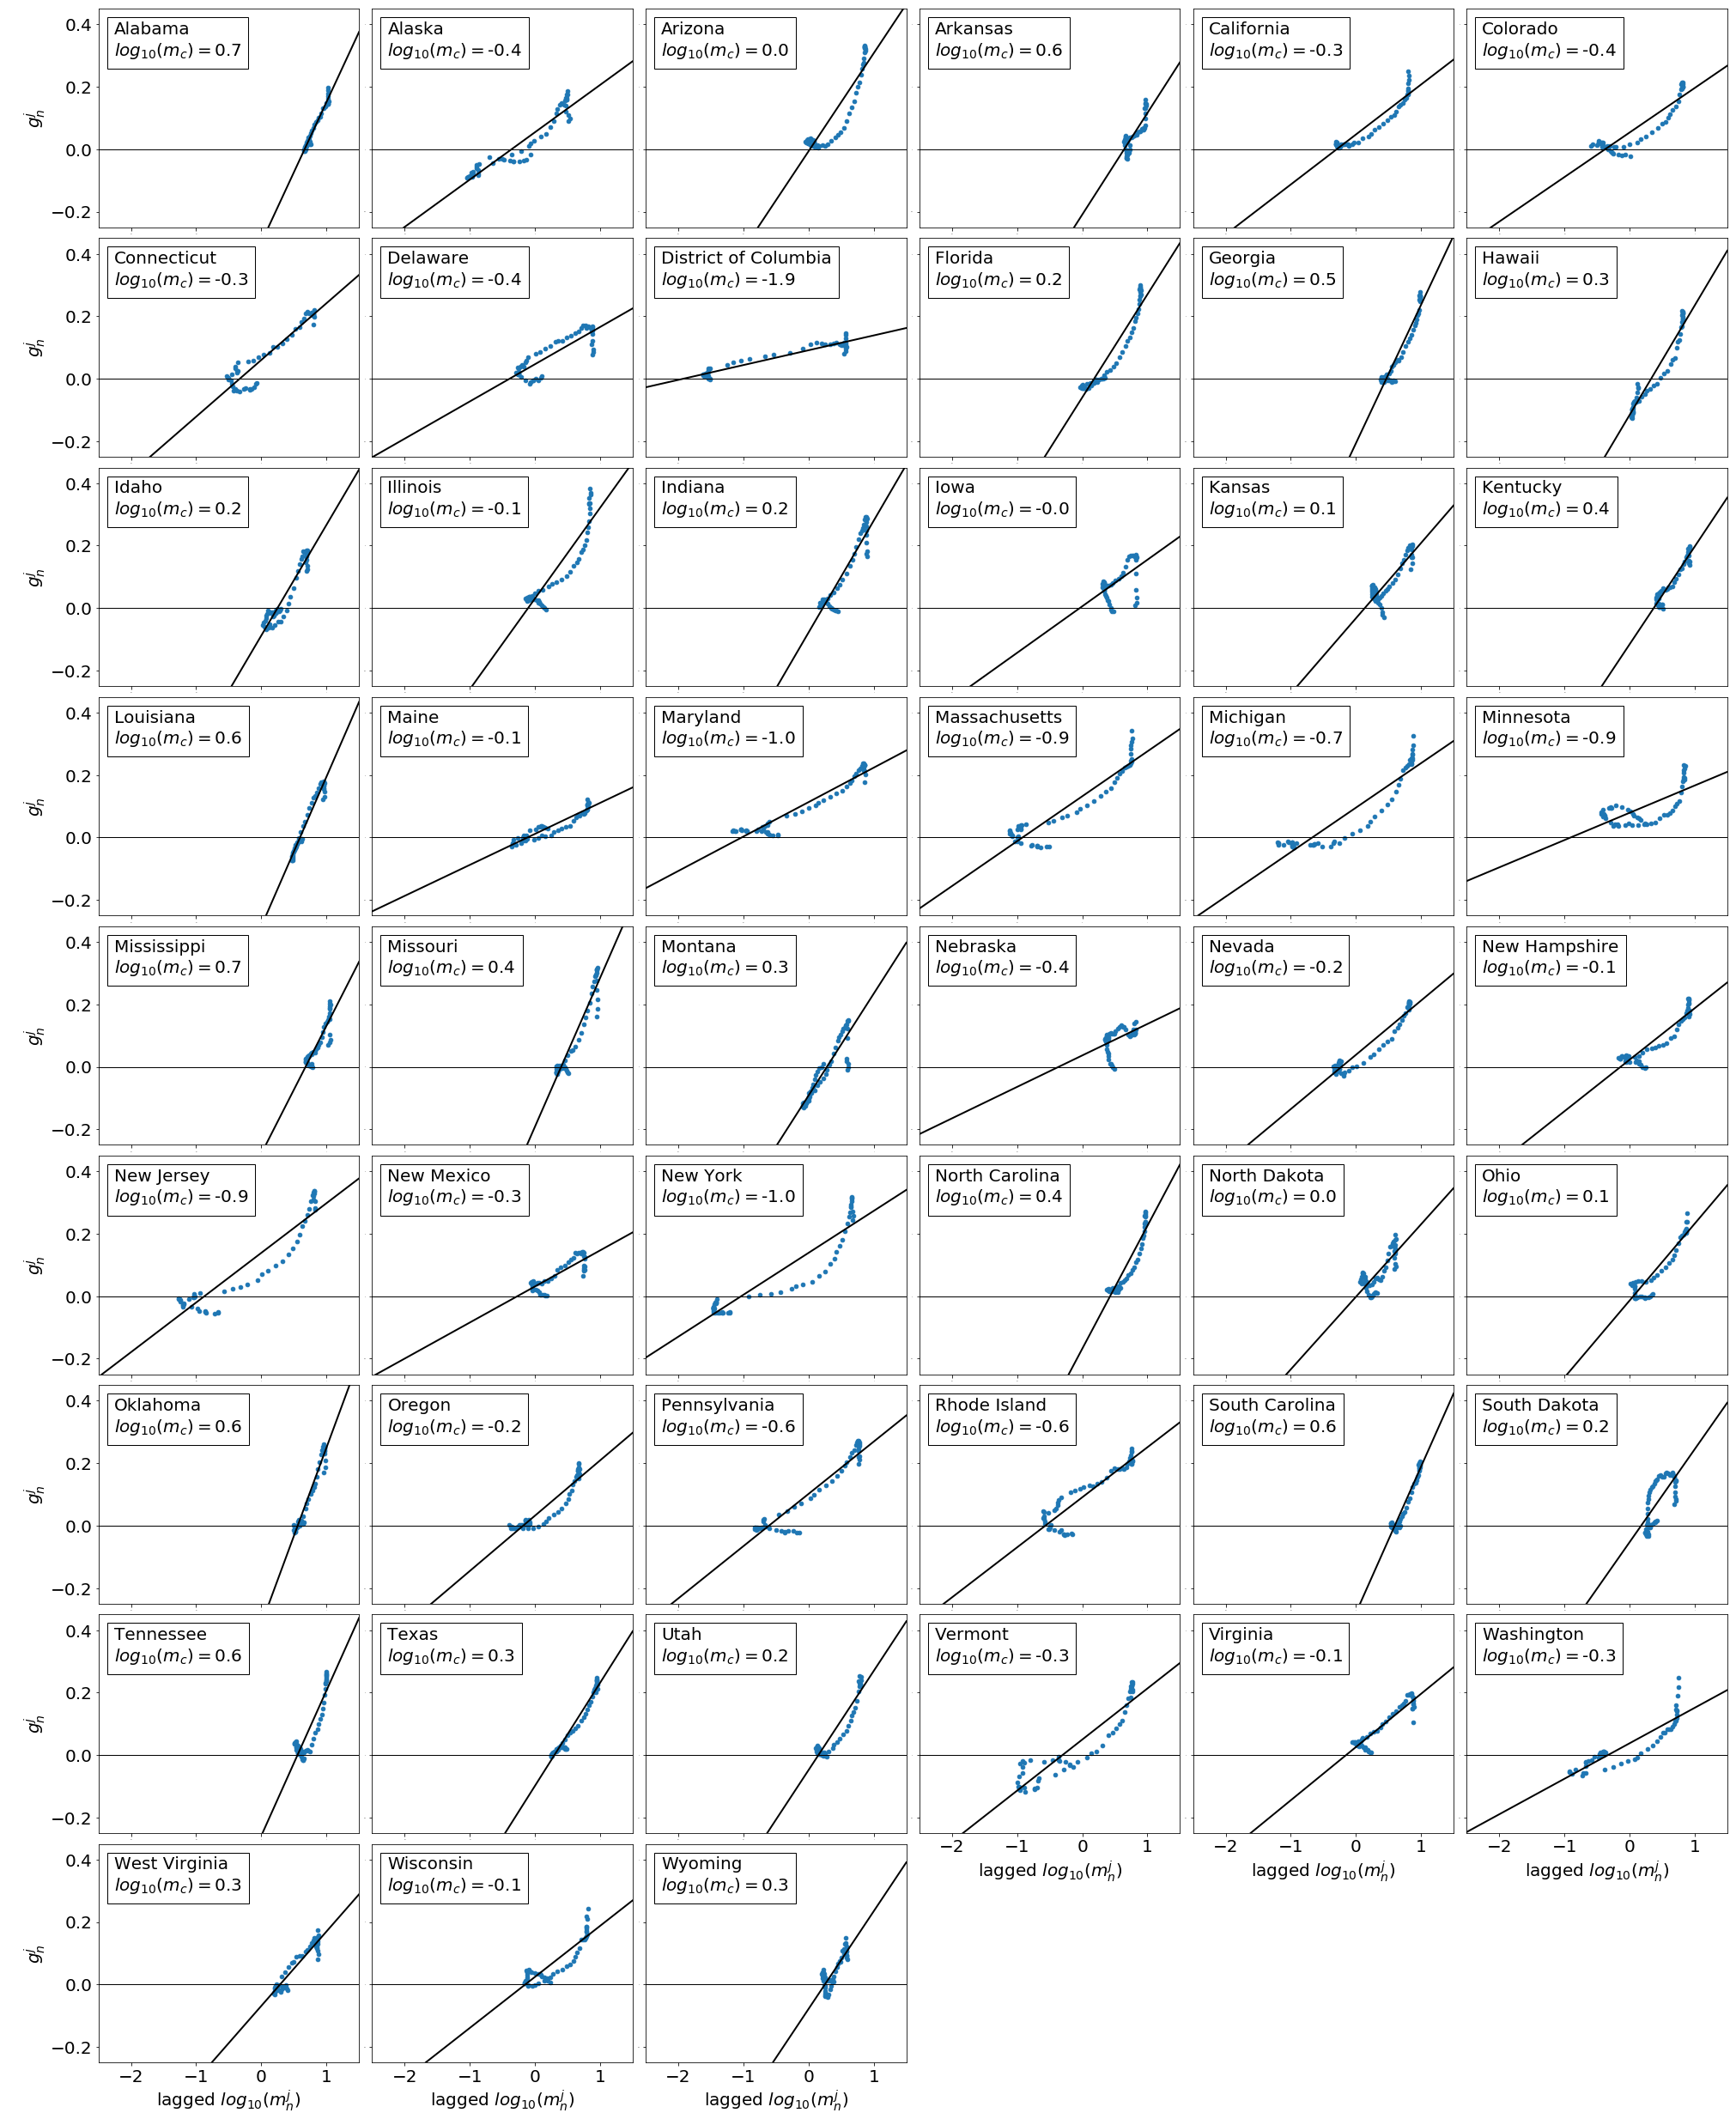

In [20]:
# Shutdown Period LogMobility
dt_cutoff_max = datetime(2020, 4, 30, tzinfo=pytz.utc)
df_plot = df_lagged[df_lagged.index<=dt_cutoff_max]
df_summary = pandas.DataFrame()

fig = plt.figure(figsize=(34, 44)) # letter size 8.5 * 11
fig.subplots_adjust(hspace=0.05, wspace=0.05)

for i, pairs_id in enumerate(df_region.sort_values(by='State')['pairs_id'].values):
    row = {}
    row['pairs_id'] = pairs_id
    row['State'] = df_region[df_region['pairs_id']==pairs_id]['State'].values[0]

    df_single = df_plot[pairs_id]
    
    if len(df_single)>0:
        ax = plt.subplot(9, 6,i+1)
        plt.scatter(df_single['LogMobility'], df_single['GrowthCases'], s=21)
        plt.axhline(color='k', lw=1)
        #plt.axvline(color='k', lw=1)

        title_string = df_region[df_region['pairs_id']==pairs_id]['State'].values[0]

        #plt.xlabel(str(cases_lag_measured) + ' days lagged log mobility $[log_{10}(m^j_n)]$', size=12)
        #plt.ylabel('Growth in cases $[(g^j_n)]$', size=12)
        if (i>44):
            plt.xlabel('lagged $log_{10}(m^j_n)$', size=20)
            plt.xticks(fontsize=20)
        else:
            plt.xticks(fontsize=0)
        if (i%6==0):
            plt.ylabel('\n$g^j_n$', size=20)
            plt.yticks(fontsize=20)
        else:
            plt.yticks(fontsize=0)
        #plt.xticks(fontsize=32)
        #plt.yticks(fontsize=24)

        try:
            # Linear Regression
            X = df_single['LogMobility']
            X = sm.add_constant(X) #intercept
            y = df_single['GrowthCases']
            model = sm.OLS(y, X)
            results = model.fit()
            #print('Parameters: ', results.params)
            #print('R2: ', results.rsquared)
            b0 = results.params.const
            b1 = results.params.LogMobility
            
            row['b0'] = b0
            row['b1'] = b1
            row['log_10(m_c)'] = -b0/b1
            row['R2'] = numpy.round(results.rsquared, 2)

            x1 = -2.5 #df_single['LogMobility'].min() #-1
            x2 = 1.5 #df_single['LogMobility'].max() #2.5
            plt.plot([x1, x2], [b1*x1+b0, b1*x2+b0], lw=2, c='k')
            
            ax.locator_params(tight=True, nbins=4)
            
            plt.xlim(xmin=-2.5, xmax=1.5)
            plt.ylim(ymin=-0.25, ymax=0.45)
            
            anchored_text = AnchoredText(title_string + '\n$log_{10}(m_c)=$' + str(numpy.round(row['log_10(m_c)'], 1)), loc=2, prop=dict(size=20))
            ax.add_artist(anchored_text)

            df_summary = df_summary.append(pandas.DataFrame(row, index=[0]))

        except: 
            pass
        

#plt.tight_layout()
plt.savefig(os.path.join(data_subdirectory, 'state_fits_RW14.svg'))
plt.show()

df_summary['R'] = numpy.sqrt(df_summary['R2']) * numpy.sign(df_summary['b1'])
df_summary = numpy.round(df_summary.rename(columns={'b0':'intercept', 'b1':'slope', 'R2':'R-squared'}), 3)

In [21]:
df_summary.describe()

R-squared  intercept      slope  log_10(m_c)    pairs_id          R
count  51.000000  51.000000  51.000000    51.000000   51.000000  51.000000
mean    0.825882  -0.036353   0.251686    -0.078706  146.000000   0.903686
std     0.152081   0.125940   0.128765     0.533287   14.866069   0.097748
min     0.230000  -0.316000   0.047000    -1.917000  121.000000   0.480000
25%     0.805000  -0.095500   0.150500    -0.344500  133.500000   0.897000
50%     0.870000   0.006000   0.232000    -0.038000  146.000000   0.933000
75%     0.910000   0.048500   0.330000     0.294000  158.500000   0.954000
max     0.970000   0.139000   0.566000     0.679000  171.000000   0.985000

In [22]:
# Log scale correlation
numpy.round(df_summary[['slope', 'R']].describe().T, 3)

count   mean    std    min    25%    50%    75%    max
slope   51.0  0.252  0.129  0.047  0.150  0.232  0.330  0.566
R       51.0  0.904  0.098  0.480  0.897  0.933  0.954  0.985

In [23]:
cols = ['State', 'R', 'slope', 'log_10(m_c)']
df_summary[cols].to_csv(os.path.join(data_subdirectory, 'state_fits_RW14_summary.csv'), index=False)
df_summary[cols].set_index('State')

R  slope  log_10(m_c)
State                                          
Alabama               0.985  0.450        0.664
Alaska                0.949  0.152       -0.359
Arizona               0.922  0.314        0.019
Arkansas              0.831  0.326        0.643
California            0.954  0.160       -0.295
Colorado              0.906  0.143       -0.375
Connecticut           0.949  0.182       -0.330
Delaware              0.866  0.119       -0.388
District of Columbia  0.964  0.047       -1.917
Florida               0.949  0.330        0.182
Georgia               0.964  0.444        0.467
Hawaii                0.970  0.351        0.332
Idaho                 0.954  0.355        0.248
Illinois              0.917  0.291       -0.105
Indiana               0.938  0.358        0.218
Iowa                  0.583  0.149       -0.038
Kansas                0.866  0.241        0.136
Kentucky              0.959  0.313        0.371
Louisiana             0.985  0.479        0.594
Maine                 0.949  0.099       -0.114
Maryland              0.964  0.110       -1.027
Massachusetts         0.933  0.144       -0.917
Michigan              0.922  0.143       -0.668
Minnesota             0.700  0.087       -0.903
Mississippi           0.900  0.410        0.679
Missouri              0.959  0.477        0.402
Montana               0.917  0.326        0.280
Nebraska              0.480  0.101       -0.362
Nevada                0.959  0.174       -0.221
New Hampshire         0.922  0.165       -0.137
New Jersey            0.933  0.159       -0.874
New Mexico            0.849  0.116       -0.271
New York              0.927  0.134       -1.035
North Carolina        0.943  0.394        0.427
North Dakota          0.787  0.232        0.009
Ohio                  0.933  0.247        0.057
Oklahoma              0.980  0.566        0.558
Oregon                0.933  0.177       -0.180
Pennsylvania          0.954  0.167       -0.608
Rhode Island          0.917  0.160       -0.566
South Carolina        0.970  0.469        0.597
South Dakota          0.700  0.298        0.178
Tennessee             0.894  0.465        0.556
Texas                 0.980  0.330        0.299
Utah                  0.938  0.318        0.151
Vermont               0.927  0.164       -0.303
Virginia              0.938  0.171       -0.150
Washington            0.883  0.114       -0.330
West Virginia         0.954  0.238        0.289
Wisconsin             0.889  0.164       -0.147
Wyoming               0.843  0.313        0.250